# 1. Belgium Netherlands Border

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from datetime import datetime
from PIL import Image
import random
from tabulate import tabulate
import time
import json

# Set global random seed
seed = 42
random.seed(seed)
np.random.seed(seed)

In [85]:
def find_unique_colors(image_path):
    """
    Finds all unique RGB colors in an image.
    """
    # Load image and convert to RGB
    img = Image.open(image_path).convert('RGB')
    img_arr = np.array(img)

    # Flatten image pixels into (num_pixels, 3)
    pixels = img_arr.reshape(-1, 3)

    # Get unique RGB colors
    unique_colors = np.unique(pixels, axis=0)

    print(f"Found {len(unique_colors)} unique colors:")
    for color in unique_colors:
        print(f"RGB{tuple(color)}")

    return unique_colors

unique_colors = find_unique_colors("border.png")


Found 2 unique colors:
RGB(138, 43, 226)
RGB(255, 165, 0)


## 1.1 Image Processing and Dataset Creation

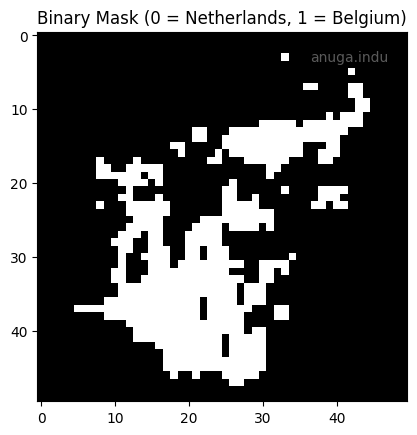

Sample data points:
((0.3469387755102041, 0.7142857142857143), 1)
((0.3469387755102041, 0.16326530612244897), 0)
((0.1836734693877551, 0.8775510204081632), 0)
((0.14285714285714285, 0.9183673469387755), 0)
((0.46938775510204084, 0.4897959183673469), 0)


In [86]:
# 1. Binary Mask Conversion
def image_to_binary_mask(image_path):
    """
    Converts the pixelated border image into a binary mask.
    Orange (Netherlands) → 0
    Purple (Belgium) → 1
    """
    # Load image and convert it into numpy array
    img = Image.open(image_path).convert('RGB')
    img_arr = np.array(img)

    # Define RGB colors for each country
    ORANGE = np.array([255, 165, 0])     # Netherlands
    PURPLE = np.array([138, 43, 226])    # Belgium

    # Create a binary mask (same size as the image)
    mask = np.zeros((img_arr.shape[0], img_arr.shape[1]), dtype=np.uint8)

    # Mark Belgium (purple pixels) as 1
    mask[np.all(img_arr == PURPLE, axis=-1)] = 1

    return mask


mask = image_to_binary_mask("border.png")
plt.imshow(mask, cmap='gray')
plt.title("Binary Mask (0 = Netherlands, 1 = Belgium)")
plt.text(0.95, 0.95, "anuga.indu", ha='right', va='top',
         transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)
plt.show()


# 2. Dataset Class
class Datasetcls:
    """
    Dataset class that returns shuffled samples of ((x, y), L)
    where:
      (x, y) → pixel coordinates normalized to [0, 1]
      L → label (0 or 1)
    """
    def __init__(self, mask):
        self.mask = mask
        self.h, self.w = mask.shape

        # Precompute all (x, y, label) tuples
        self.data = [((x / (self.w - 1), y / (self.h - 1)), mask[y, x])
                     for y in range(self.h)
                     for x in range(self.w)]

    def __len__(self):
        return len(self.data)

    def get_all_samples(self, shuffle=True):
        """Returns all ((x, y), L) samples, optionally shuffled"""
        if shuffle:
            random.shuffle(self.data)
        return self.data


# Load image and make mask
image_path = "border.png"   
mask = image_to_binary_mask(image_path)

dataset = Datasetcls(mask)

# Retrieve shuffled samples
samples = dataset.get_all_samples(shuffle=True)

# Print first 5 samples
print("Sample data points:")
for i in range(5):
    print(samples[i])

## 1.2 Neural Network Implementation from Scratch

### Activation Function Classes

In [87]:
class ReLU:
    def forward(self, x):
        self.x = x  # Cache input for backward
        return np.maximum(0, x)
    
    def backward(self):
        return (self.x > 0).astype(float)

class Tanh:
    def forward(self, x):
        self.out = np.tanh(x)
        return self.out
    
    def backward(self): 
        return 1 - self.out**2

class Sigmoid:
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        return self.out
    
    def backward(self):
        return self.out * (1 - self.out)

class Identity:
    def forward(self, x):
        return x
    
    def backward(self):  
        return np.ones_like(x) if hasattr(self, 'x') else 1

### Linear Layer Class

In [88]:
class LinearLayer:
    def __init__(self, in_features, out_features, activation):
        """
        Initializes the Linear layer.
        Arguments:
            in_features  -> number of input neurons
            out_features -> number of output neurons
            activation   -> activation function class 
        """
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation

        # Initialize weights and biases
        if isinstance(activation, (Tanh, Sigmoid)):
            # Xavier initialization: For Sigmoid/Tanh
            self.W = np.random.randn(in_features, out_features) * np.sqrt(2 / (in_features + out_features))
        elif isinstance(activation, ReLU):
            # He initialization: For ReLU
            self.W = np.random.randn(in_features, out_features) * np.sqrt(2 / in_features)
        else:
            # Default initialization (e.g., for Identity or unknown activations)
            self.W = np.random.randn(in_features, out_features) * 0.01

        self.b = np.zeros((1, out_features))

        # Forward pass cache
        self.x = None
        self.z = None
        self.out = None

        # Cumulative gradients for backprop
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, x):
        """
        Forward pass: computes output = activation(xW + b)
        """
        self.x = x                                  # Save input
        self.z = np.dot(x, self.W) + self.b         # Linear transformation
        self.out = self.activation.forward(self.z)  # Apply activation
        return self.out

    def backward(self, grad_output):
        """
        Backward pass:
        grad_output -> gradient coming from the next layer
        Returns: gradient w.r.t input of this layer
        """
        # Derivative of activation
        grad_activation = self.activation.backward()
        
        # Multiply by gradient from next layer
        delta = grad_output * grad_activation  

        # Compute gradients
        self.dW += np.dot(self.x.T, delta)
        self.db += np.sum(delta, axis=0, keepdims=True)

        # Return gradient to pass backward
        grad_input = np.dot(delta, self.W.T)
        return grad_input

    def zero_grad(self):
        """Reset gradients to zero before new accumulation"""
        self.dW.fill(0)
        self.db.fill(0)


### Model Class

In [89]:
class Model:
    def __init__(self, layers, loss_type='MSE', lr=0.01):
        """
        Arguments:
            layers    -> list of LinearLayer instances
            loss_type -> 'MSE' or 'BCE'
            lr        -> learning rate
        """
        self.layers = layers
        self.loss_type = loss_type
        self.lr = lr
        self.grad_accum_count = 0  # Track accumulation steps

    def forward(self, x):
        """Sequentially run forward pass through all layers"""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, y_pred, y_true):
        """Perform backward pass through all layers"""
        # Compute initial gradient from loss
        grad = self.loss_backward(y_pred, y_true)

        # Backpropagate through all layers in reverse order
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    # def loss_forward(self, y_pred, y_true):
    #     """Compute loss value"""
    #     if self.loss_type == 'MSE':
    #         return np.mean((y_pred - y_true) ** 2)
    #     elif self.loss_type == 'BCE':
    #         eps = 1e-8  # to prevent log(0)
    #         return -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))
    #     else:
    #         raise ValueError("Unsupported loss type")
        
    def loss_forward(self, y_pred, y_true):
        """Compute loss value"""
        eps = 1e-8  # to prevent log(0)
        if self.loss_type == 'MSE':
            return np.mean((y_pred - y_true) ** 2)
        elif self.loss_type == 'BCE':
            # Clip predictions to avoid log(0) or log(1)
            y_pred = np.clip(y_pred, eps, 1 - eps)
            return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        else:
            raise ValueError("Unsupported loss type")

    def loss_backward(self, y_pred, y_true):
        """Compute derivative of loss w.r.t predictions"""
        if self.loss_type == 'MSE':
            return 2 * (y_pred - y_true) / y_true.shape[0]
        elif self.loss_type == 'BCE':
            eps = 1e-8
            return ((1 - y_true) / (1 - y_pred + eps) - y_true / (y_pred + eps)) / y_true.shape[0]
        else:
            raise ValueError("Unsupported loss type")

    def train(self, x, y):
        """
        One training step:
          1. Forward pass
          2. Compute loss
          3. Backward pass (accumulate gradients)
        """
        y_pred = self.forward(x)
        loss = self.loss_forward(y_pred, y)
        self.backward(y_pred, y)
        return loss

    def zero_grad(self):
        """Reset gradients in all layers"""
        for layer in self.layers:
            layer.zero_grad()

    def update(self):
        """Gradient descent parameter update"""
        for layer in self.layers:
            layer.W -= self.lr * layer.dW
            layer.b -= self.lr * layer.db
            # layer.zero_grad()  # Reset after update
        self.zero_grad()

    def predict(self, x):
        """Return predicted outputs"""
        return self.forward(x)

    def save_to(self, path):
        """Save model parameters to .npz file"""
        params = {}
        for i, layer in enumerate(self.layers):
            params[f"W{i}"] = layer.W
            params[f"b{i}"] = layer.b
        np.savez(path, **params)

    def load_from(self, path):
        """Load model parameters from .npz file"""
        data = np.load(path)
        for i, layer in enumerate(self.layers):
            W_key, b_key = f"W{i}", f"b{i}"
            if layer.W.shape != data[W_key].shape or layer.b.shape != data[b_key].shape:
                raise ValueError("Model architecture does not match saved parameters.")
            layer.W = data[W_key]
            layer.b = data[b_key]


### Training Procedure

In [90]:
def train_model(model, dataset, num_epochs=10, batch_size=32, grad_accum_steps=1):
    """
    Trains the model using the given dataset.
    Parameters:
        model              -> instance of Model
        dataset            -> instance of Dataset
        num_epochs         -> number of training epochs
        batch_size         -> samples per batch
        grad_accum_steps   -> number of batches before performing an update
    """

    # Create a unique run folder
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = f"runs/{timestamp}"
    os.makedirs(run_dir, exist_ok=True)

    all_samples = dataset.get_all_samples(shuffle=True)
    num_samples = len(all_samples)

    losses = []
    samples_seen = []

    print(f"\nStarting training for {num_epochs} epochs...")
    total_batches = num_samples // batch_size

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        np.random.shuffle(all_samples)

        # Iterate through all batches
        for i in tqdm(range(total_batches), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):

            batch = all_samples[i * batch_size:(i + 1) * batch_size]

            # Separate inputs and labels
            X = np.array([p[0] for p in batch])
            y = np.array([[p[1]] for p in batch])  # shape (batch, 1)

            # Perform forward + backward (no parameter update yet)
            loss = model.train(X, y)
            epoch_loss += loss

            # Gradient accumulation logic
            if (i + 1) % grad_accum_steps == 0 or (i + 1) == total_batches:
                model.update()

            # Track progress (samples seen so far)
            samples_processed = (epoch * total_batches + i + 1) * batch_size
            losses.append(loss)
            samples_seen.append(samples_processed)

        avg_epoch_loss = epoch_loss / total_batches
        print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_epoch_loss:.6f}")

    # Save training loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(samples_seen, losses, label='Training Loss')
    plt.xlabel("Samples Seen")
    plt.ylabel("Loss")
    plt.title("Training Loss vs. Samples Seen")
    plt.legend()
    plt.grid(True)
    plt.text(0.95, 0.95, "anuga.indu", ha='right', va='top',
         transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)
    plt.tight_layout()

    loss_plot_path = os.path.join(run_dir, "training_loss.png")
    plt.savefig(loss_plot_path)
    plt.close()

    # Save model parameters
    model_path = os.path.join(run_dir, "model_params.npz")
    model.save_to(model_path)

    print(f"\nTraining complete! Results saved in folder: {run_dir}")
    print(f"   - Loss plot: {loss_plot_path}")
    print(f"   - Model parameters: {model_path}")

    return losses, samples_seen


### Early Stopping

In [91]:
def train_model2(
    model,
    dataset,
    num_epochs=100,
    batch_size=32,
    grad_accum_steps=1,
    patience=10,
    relative_loss_threshold=0.01
):
    """
    Trains the model with early stopping based on training loss.

    Parameters:
        model                     -> Model instance
        dataset                   -> Dataset instance
        num_epochs                -> maximum number of epochs to train
        batch_size                -> samples per batch
        grad_accum_steps           -> batches before updating weights
        patience                  -> number of epochs to look back for early stopping
        relative_loss_threshold   -> minimum relative improvement (e.g., 0.01 = 1%)
    """

    # Create unique folder for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = f"runs/{timestamp}"
    os.makedirs(run_dir, exist_ok=True)

    all_samples = dataset.get_all_samples(shuffle=True)
    num_samples = len(all_samples)
    total_batches = num_samples // batch_size

    losses = []         # batch-wise loss
    samples_seen = []   # samples count for plotting
    epoch_losses = []   # average loss per epoch

    print(f"\nStarting training for up to {num_epochs} epochs (early stopping enabled)...")

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        # np.random.shuffle(all_samples)
        all_samples = dataset.get_all_samples(shuffle=True)

        for i in tqdm(range(total_batches), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            batch = all_samples[i * batch_size:(i + 1) * batch_size]

            X = np.array([p[0] for p in batch])
            y = np.array([[p[1]] for p in batch])  # shape (batch_size, 1)

            # Forward + backward
            loss = model.train(X, y)
            epoch_loss += loss

            # Gradient accumulation
            if (i + 1) % grad_accum_steps == 0 or (i + 1) == total_batches:
                model.update()

            # Track progress
            samples_seen.append((epoch * total_batches + i + 1) * batch_size)
            losses.append(loss)

        avg_epoch_loss = epoch_loss / total_batches
        epoch_losses.append(avg_epoch_loss)
        # print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_epoch_loss:.6f}")

        # ---------- EARLY STOPPING CHECK ----------
        if epoch >= patience:
            # Compare current loss with loss from 'patience' epochs ago
            past_loss = epoch_losses[-patience - 1]
            if avg_epoch_loss >= (1 - relative_loss_threshold) * past_loss:
                print(f"\nEarly stopping triggered at epoch {epoch+1}!")
                print(f"Loss improvement < {relative_loss_threshold*100:.1f}% over last {patience} epochs.")
                break

    # Save training loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(samples_seen, losses, label='Training Loss')
    plt.xlabel("Samples Seen")
    plt.ylabel("Loss")
    plt.title("Training Loss vs. Samples Seen")
    plt.legend()
    plt.grid(True)
    plt.text(0.95, 0.95, "anuga.indu", ha='right', va='top',
         transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)
    plt.tight_layout()

    loss_plot_path = os.path.join(run_dir, "training_loss.png")
    plt.savefig(loss_plot_path)
    plt.close()

    # Save model parameters
    model_path = os.path.join(run_dir, "model_params.npz")
    model.save_to(model_path)

    print(f"\nTraining complete! Results saved in folder: {run_dir}")
    print(f"   - Loss plot: {loss_plot_path}")
    print(f"   - Model parameters: {model_path}")

    return losses, samples_seen, epoch_losses


## 1.3 Sanity Check

### 1.3.1 The XOR Problem

In [92]:
# XOR Dataset Class
class XORDataset:
    """
    Dataset for the XOR function: {0,1} × {0,1} → {0,1}
    Returns samples in format ((x1, x2), label) where label = x1 XOR x2
    """
    def __init__(self):
        # All possible XOR inputs and outputs
        self.data = [
            ((0.0, 0.0), 0),  # 0 XOR 0 = 0
            ((0.0, 1.0), 1),  # 0 XOR 1 = 1
            ((1.0, 0.0), 1),  # 1 XOR 0 = 1
            ((1.0, 1.0), 0)   # 1 XOR 1 = 0
        ]
    
    def __len__(self):
        return len(self.data)
    
    def get_all_samples(self, shuffle=True):
        """Returns all samples, optionally shuffled"""
        if shuffle:
            data_copy = self.data.copy()
            random.shuffle(data_copy)
            return data_copy
        return self.data.copy()


def calculate_xor_accuracy(model, dataset):
    """
    Calculate accuracy on XOR dataset.
    """
    correct = 0
    samples = dataset.get_all_samples(shuffle=False)
    
    for (x_input, y_label) in samples:
        X = np.array([x_input])
        prediction = model.predict(X)[0, 0]
        
        # Round prediction to 0 or 1
        pred_class = 1 if prediction > 0.5 else 0
        
        if pred_class == y_label:
            correct += 1
    
    return correct / len(samples)


def test_xor_predictions(model, dataset):
    """
    Print predictions for all XOR inputs.
    """
    print("\nXOR Predictions:")
    print("=" * 50)
    samples = dataset.get_all_samples(shuffle=False)
    
    for (x_input, y_label) in samples:
        X = np.array([x_input])
        prediction = model.predict(X)[0, 0]
        pred_class = 1 if prediction > 0.5 else 0
        
        x1, x2 = x_input
        correct = "✓" if pred_class == y_label else "✗"
        print(f"Input: ({x1:.0f}, {x2:.0f}) | Predicted: {prediction:.4f} → {pred_class} | "
              f"True: {y_label} | {correct}")
    
    accuracy = calculate_xor_accuracy(model, dataset)
    print(f"\nAccuracy: {accuracy:.2%}")
    return accuracy


def run_xor_experiments():
    """
    Run XOR experiments with various architectures and activation functions.
    Ensures each activation is used at least once in hidden layers AND at least once in final layer.
    """
    datasetXOR = XORDataset()
    
    # Define architectures that satisfy the requirement:
    # Each activation (ReLU, Tanh, Sigmoid, Identity) must appear:
    # - At least once in a hidden layer (across all models)
    # - At least once in the final layer (across all models)
    
    architectures = [
        # Each activation as HIDDEN layer with Sigmoid output
        {"name": "2-4(ReLU)-1(Sigmoid)", "hidden_activations": [ReLU()], "hidden_sizes": [4], "output_activation": Sigmoid()},
        {"name": "2-4(Tanh)-1(Sigmoid)", "hidden_activations": [Tanh()], "hidden_sizes": [4], "output_activation": Sigmoid()},
        {"name": "2-4(Sigmoid)-1(Sigmoid)", "hidden_activations": [Sigmoid()], "hidden_sizes": [4], "output_activation": Sigmoid()},
        {"name": "2-4(Identity)-1(Sigmoid)", "hidden_activations": [Identity()], "hidden_sizes": [4], "output_activation": Sigmoid()},
        
        # Each activation as FINAL layer with ReLU hidden
        {"name": "2-8(ReLU)-1(ReLU)", "hidden_activations": [ReLU()], "hidden_sizes": [8], "output_activation": ReLU()},
        {"name": "2-8(ReLU)-1(Tanh)", "hidden_activations": [ReLU()], "hidden_sizes": [8], "output_activation": Tanh()},
        {"name": "2-8(ReLU)-1(Identity)", "hidden_activations": [ReLU()], "hidden_sizes": [8], "output_activation": Identity()},
        
        # Multi-layer architectures with various combinations
        # {"name": "2-8(ReLU)-4(Tanh)-1(Sigmoid)", "hidden_activations": [ReLU(), Tanh()], "hidden_sizes": [8, 4], "output_activation": Sigmoid()},
        # {"name": "2-8(Sigmoid)-4(ReLU)-1(Tanh)", "hidden_activations": [Sigmoid(), ReLU()], "hidden_sizes": [8, 4], "output_activation": Tanh()},
        # {"name": "2-16(Tanh)-8(Sigmoid)-1(ReLU)", "hidden_activations": [Tanh(), Sigmoid()], "hidden_sizes": [16, 8], "output_activation": ReLU()},
        {"name": "2-8(Identity)-4(ReLU)-1(Sigmoid)", "hidden_activations": [Identity(), ReLU()], "hidden_sizes": [8, 4], "output_activation": Sigmoid()},
        
        # Additional varied architectures
        {"name": "2-6(Tanh)-1(Identity)", "hidden_activations": [Tanh()], "hidden_sizes": [6], "output_activation": Identity()},
        # {"name": "2-10(Sigmoid)-5(Tanh)-1(ReLU)", "hidden_activations": [Sigmoid(), Tanh()], "hidden_sizes": [10, 5], "output_activation": ReLU()},
    ]
    
    results = []
    
    for arch in architectures:
        print(f"\nArchitecture: {arch['name']}")
        print(f"{'='*70}")
        
        # Build model
        layers = []
        input_size = 2
        
        # Add hidden layers
        for i, hidden_size in enumerate(arch['hidden_sizes']):
            activation = arch['hidden_activations'][i]
            layers.append(LinearLayer(input_size, hidden_size, activation))
            input_size = hidden_size
        
        # Add output layer
        layers.append(LinearLayer(input_size, 1, arch['output_activation']))
        
        # Create model with BCE loss (better for binary classification)
        model = Model(layers, loss_type='BCE', lr=0.1)
        
        # Train the model using train_model2 function with early stopping
        losses, samples_seen, epoch_losses = train_model2(
            model=model,
            dataset=datasetXOR,
            num_epochs=1000,
            batch_size=4,  # All 4 XOR samples in one batch
            grad_accum_steps=1,
            patience=50,
            relative_loss_threshold=0.001
        )
        
        # Test predictions after training
        final_accuracy = test_xor_predictions(model, datasetXOR)
        
        # Store results
        results.append({
            "architecture": arch['name'],
            "final_accuracy": final_accuracy,
            "converged": final_accuracy == 1.0,
            "epochs": len(epoch_losses),
            "final_loss": epoch_losses[-1]
        })
        
        if final_accuracy == 1.0:
            print("✓ Model converged to 100% accuracy!")
        else:
            print("✗ Model did NOT achieve 100% accuracy")
    
    return results



# - without train_model2 fun
# def run_xor_experiments():
#     """
#     Run XOR experiments with various architectures and activation functions.
#     """
#     datasetXOR = XORDataset()
#     architectures = [
#         {"name": "2-4(ReLU)-1(Sigmoid)", "hidden_activations": [ReLU()], "hidden_sizes": [4], "output_activation": Sigmoid(), "lr": 0.1},
#         {"name": "2-4(Tanh)-1(Sigmoid)", "hidden_activations": [Tanh()], "hidden_sizes": [4], "output_activation": Sigmoid(), "lr": 0.1},
#         {"name": "2-4(Identity)-1(Sigmoid)", "hidden_activations": [Identity()], "hidden_sizes": [4], "output_activation": Sigmoid(), "lr": 0.1},
#         {"name": "2-8(ReLU)-1(ReLU)", "hidden_activations": [ReLU()], "hidden_sizes": [8], "output_activation": ReLU(), "lr": 0.1},
#         {"name": "2-8(ReLU)-1(Tanh)", "hidden_activations": [ReLU()], "hidden_sizes": [8], "output_activation": Tanh(), "lr": 0.1},
#         {"name": "2-8(Sigmoid)-1(Tanh)", "hidden_activations": [Sigmoid()], "hidden_sizes": [8], "output_activation": Tanh(), "lr": 0.1},
#         {"name": "2-8(ReLU)-1(Identity)", "hidden_activations": [ReLU()], "hidden_sizes": [8], "output_activation": Identity(), "lr": 0.1},
#     ]
#     results = []
#     for arch in architectures:
#         print(f"\nArchitecture: {arch['name']}")
#         print(f"{'='*70}")
#         # Build model
#         layers = []
#         input_size = 2
#         for i, hidden_size in enumerate(arch['hidden_sizes']):
#             activation = arch['hidden_activations'][i]
#             layers.append(LinearLayer(input_size, hidden_size, activation))
#             input_size = hidden_size
#         layers.append(LinearLayer(input_size, 1, arch['output_activation']))
#         # Higher learning rate for XOR
#         model = Model(layers, loss_type='BCE', lr=arch.get('lr', 0.1))
#         # Train manually without creating run directories
#         max_epochs = 5000
#         batch_size = 4
#         all_samples = datasetXOR.get_all_samples(shuffle=True)
#         epoch_losses = []
#         for epoch in range(max_epochs):
#             all_samples = datasetXOR.get_all_samples(shuffle=True)
#             X = np.array([p[0] for p in all_samples])
#             y = np.array([[p[1]] for p in all_samples])
#             loss = model.train(X, y)
#             model.update()
#             epoch_losses.append(loss)
#             # Check convergence
#             if loss < 0.001:  # Very low loss threshold
#                 print(f"Converged at epoch {epoch+1}")
#                 break
#         # Test predictions
#         final_accuracy = test_xor_predictions(model, datasetXOR)
#         results.append({
#             "architecture": arch['name'],
#             "final_accuracy": final_accuracy,
#             "converged": final_accuracy == 1.0,
#             "epochs": epoch + 1,
#             "final_loss": epoch_losses[-1] if epoch_losses else float('inf')
#         })
#         if final_accuracy == 1.0:
#             print("✓ Model converged to 100% accuracy!")
#         else:
#             print(f"✗ Model achieved {final_accuracy:.2%} accuracy")
#     return results



resultsXOR = run_xor_experiments()


def print_results_table_with_serial(results):
    """
    Prints a table of results for each architecture with a serial number.
    Arguments:
        results -> List of dictionaries containing architecture details and accuracy.
    """
    # Prepare table data
    table_data = []
    for idx, result in enumerate(results, start=1):  # Add serial number starting from 1
        table_data.append([
            idx,  # Serial number
            result["architecture"],  # Architecture name
            f"{result['final_accuracy']:.2%}",  # Accuracy as percentage
            "Yes" if result["converged"] else "No",  # Convergence status
            result["epochs"],  # Number of epochs
            f"{result['final_loss']:.6f}" if result["final_loss"] is not None else "nan"  # Final loss
        ])
    
    # Define table headers
    headers = ["S.No.", "Architecture", "Accuracy", "Converged", "Epochs", "Final Loss"]
    
    # Print table
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

print()
print_results_table_with_serial(resultsXOR)



Architecture: 2-4(ReLU)-1(Sigmoid)

Starting training for up to 1000 epochs (early stopping enabled)...



Training complete! Results saved in folder: runs/20251015_233145
   - Loss plot: runs/20251015_233145\training_loss.png
   - Model parameters: runs/20251015_233145\model_params.npz

XOR Predictions:
Input: (0, 0) | Predicted: 0.1631 → 0 | True: 0 | ✓
Input: (0, 1) | Predicted: 0.9411 → 1 | True: 1 | ✓
Input: (1, 0) | Predicted: 0.9647 → 1 | True: 1 | ✓
Input: (1, 1) | Predicted: 0.0322 → 0 | True: 0 | ✓

Accuracy: 100.00%
✓ Model converged to 100% accuracy!

Architecture: 2-4(Tanh)-1(Sigmoid)

Starting training for up to 1000 epochs (early stopping enabled)...



Training complete! Results saved in folder: runs/20251015_233149
   - Loss plot: runs/20251015_233149\training_loss.png
   - Model parameters: runs/20251015_233149\model_params.npz

XOR Predictions:
Input: (0, 0) | Predicted: 0.0099 → 0 | True: 0 | ✓
Input: (0, 1) | Predicted: 0.9562 → 1 | True: 1 | ✓
Input: (1, 0) | Predicted: 0.9584 → 1 | True: 1 | ✓
Input: (1, 1) | Predicted: 0.0607 → 0 | True: 0 | ✓

Accuracy: 100.00%
✓ Model converged to 100% accuracy!

Architecture: 2-4(Sigmoid)-1(Sigmoid)

Starting training for up to 1000 epochs (early stopping enabled)...



Early stopping triggered at epoch 102!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233153
   - Loss plot: runs/20251015_233153\training_loss.png
   - Model parameters: runs/20251015_233153\model_params.npz

XOR Predictions:
Input: (0, 0) | Predicted: 0.5336 → 1 | True: 0 | ✗
Input: (0, 1) | Predicted: 0.4952 → 0 | True: 1 | ✗
Input: (1, 0) | Predicted: 0.5034 → 1 | True: 1 | ✓
Input: (1, 1) | Predicted: 0.4674 → 0 | True: 0 | ✓

Accuracy: 50.00%
✗ Model did NOT achieve 100% accuracy

Architecture: 2-4(Identity)-1(Sigmoid)

Starting training for up to 1000 epochs (early stopping enabled)...



Early stopping triggered at epoch 51!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233153
   - Loss plot: runs/20251015_233153\training_loss.png
   - Model parameters: runs/20251015_233153\model_params.npz

XOR Predictions:
Input: (0, 0) | Predicted: 0.4998 → 0 | True: 0 | ✓
Input: (0, 1) | Predicted: 0.4984 → 0 | True: 1 | ✗
Input: (1, 0) | Predicted: 0.5016 → 1 | True: 1 | ✓
Input: (1, 1) | Predicted: 0.5002 → 1 | True: 0 | ✗

Accuracy: 50.00%
✗ Model did NOT achieve 100% accuracy

Architecture: 2-8(ReLU)-1(ReLU)

Starting training for up to 1000 epochs (early stopping enabled)...



Early stopping triggered at epoch 72!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233154
   - Loss plot: runs/20251015_233154\training_loss.png
   - Model parameters: runs/20251015_233154\model_params.npz

XOR Predictions:
Input: (0, 0) | Predicted: 0.0000 → 0 | True: 0 | ✓
Input: (0, 1) | Predicted: 2.4870 → 1 | True: 1 | ✓
Input: (1, 0) | Predicted: 4.1366 → 1 | True: 1 | ✓
Input: (1, 1) | Predicted: 0.0000 → 0 | True: 0 | ✓

Accuracy: 100.00%
✓ Model converged to 100% accuracy!

Architecture: 2-8(ReLU)-1(Tanh)

Starting training for up to 1000 epochs (early stopping enabled)...



Early stopping triggered at epoch 160!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233154
   - Loss plot: runs/20251015_233154\training_loss.png
   - Model parameters: runs/20251015_233154\model_params.npz

XOR Predictions:
Input: (0, 0) | Predicted: -0.9593 → 0 | True: 0 | ✓
Input: (0, 1) | Predicted: -1.0000 → 0 | True: 1 | ✗
Input: (1, 0) | Predicted: 0.9731 → 1 | True: 1 | ✓
Input: (1, 1) | Predicted: -0.9649 → 0 | True: 0 | ✓

Accuracy: 75.00%
✗ Model did NOT achieve 100% accuracy

Architecture: 2-8(ReLU)-1(Identity)

Starting training for up to 1000 epochs (early stopping enabled)...



Early stopping triggered at epoch 51!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233155
   - Loss plot: runs/20251015_233155\training_loss.png
   - Model parameters: runs/20251015_233155\model_params.npz

XOR Predictions:
Input: (0, 0) | Predicted: 22.2253 → 1 | True: 0 | ✗
Input: (0, 1) | Predicted: 42.0806 → 1 | True: 1 | ✓
Input: (1, 0) | Predicted: 29.5019 → 1 | True: 1 | ✓
Input: (1, 1) | Predicted: 49.0029 → 1 | True: 0 | ✗

Accuracy: 50.00%
✗ Model did NOT achieve 100% accuracy

Architecture: 2-8(Identity)-4(ReLU)-1(Sigmoid)

Starting training for up to 1000 epochs (early stopping enabled)...



Training complete! Results saved in folder: runs/20251015_233155
   - Loss plot: runs/20251015_233155\training_loss.png
   - Model parameters: runs/20251015_233155\model_params.npz

XOR Predictions:
Input: (0, 0) | Predicted: 0.0022 → 0 | True: 0 | ✓
Input: (0, 1) | Predicted: 0.9722 → 1 | True: 1 | ✓
Input: (1, 0) | Predicted: 0.9722 → 1 | True: 1 | ✓
Input: (1, 1) | Predicted: 0.0021 → 0 | True: 0 | ✓

Accuracy: 100.00%
✓ Model converged to 100% accuracy!

Architecture: 2-6(Tanh)-1(Identity)

Starting training for up to 1000 epochs (early stopping enabled)...



Early stopping triggered at epoch 51!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233158
   - Loss plot: runs/20251015_233158\training_loss.png
   - Model parameters: runs/20251015_233158\model_params.npz

XOR Predictions:
Input: (0, 0) | Predicted: -4.5609 → 0 | True: 0 | ✓
Input: (0, 1) | Predicted: 7.0665 → 1 | True: 1 | ✓
Input: (1, 0) | Predicted: -5.9765 → 0 | True: 1 | ✗
Input: (1, 1) | Predicted: 5.9164 → 1 | True: 0 | ✗

Accuracy: 50.00%
✗ Model did NOT achieve 100% accuracy

+---------+----------------------------------+------------+-------------+----------+--------------+
|   S.No. | Architecture                     | Accuracy   | Converged   |   Epochs |   Final Loss |
+=========+==================================+============+=============+==========+==============+
|       1 | 2-4(ReLU)-1(Sigmoid)             | 100.00%    | Yes         |     1000 |     0.076971 |
+---------+----------------------------------+---

### 1.3.2 Gradient Approximation

In [93]:
def gradient_check(model, X, y, epsilon=1e-5, tolerance=1e-4):
    """
    Performs gradient checking for all layers in the model.
    Arguments:
        model   -> instance of Model
        X       -> input batch (shape: batch_size x input_dim)
        y       -> true labels (shape: batch_size x 1)
        epsilon -> small perturbation for finite difference
        tolerance -> acceptable difference between numerical and backprop gradients

    Returns:
        True if gradients match within tolerance, else False
    """

    # Perform forward + backward pass to compute analytical gradients
    model.zero_grad()
    y_pred = model.forward(X)
    _ = model.train(X, y)  # accumulates gradients in layers

    print("\nGradient Check:")
    all_passed = True

    for layer_idx, layer in enumerate(model.layers):
        print(f"\nLayer {layer_idx} -> W shape: {layer.W.shape}, b shape: {layer.b.shape}")

        # Check weights
        for i in range(layer.W.shape[0]):
            for j in range(layer.W.shape[1]):
                original_value = layer.W[i, j]

                # Compute L(θ + ε)
                layer.W[i, j] = original_value + epsilon
                loss_plus = model.loss_forward(model.forward(X), y)

                # Compute L(θ - ε)
                layer.W[i, j] = original_value - epsilon
                loss_minus = model.loss_forward(model.forward(X), y)

                # Numerical gradient
                grad_numerical = (loss_plus - loss_minus) / (2 * epsilon)

                # Analytical gradient from backprop
                grad_backprop = layer.dW[i, j]

                # Relative error
                rel_error = abs(grad_numerical - grad_backprop)
                if rel_error > tolerance:
                    print(f"W[{i},{j}] -> Numerical: {grad_numerical:.6f}, "
                          f"Backprop: {grad_backprop:.6f}, Error: {rel_error:.6f} ✗")
                    all_passed = False
                # Uncomment to also print passing gradients
                # else:
                #     print(f"W[{i},{j}] -> OK")

                # Restore original value
                layer.W[i, j] = original_value

        # Check biases
        for j in range(layer.b.shape[1]):
            original_value = layer.b[0, j]

            # Compute L(θ + ε)
            layer.b[0, j] = original_value + epsilon
            loss_plus = model.loss_forward(model.forward(X), y)

            # Compute L(θ - ε)
            layer.b[0, j] = original_value - epsilon
            loss_minus = model.loss_forward(model.forward(X), y)

            # Numerical gradient
            grad_numerical = (loss_plus - loss_minus) / (2 * epsilon)

            # Analytical gradient from backprop
            grad_backprop = layer.db[0, j]

            rel_error = abs(grad_numerical - grad_backprop)
            if rel_error > tolerance:
                print(f"b[{j}] -> Numerical: {grad_numerical:.6f}, "
                      f"Backprop: {grad_backprop:.6f}, Error: {rel_error:.6f} ✗")
                all_passed = False
            # Restore original value
            layer.b[0, j] = original_value

    if all_passed:
        print("\n✅ Gradient check passed for all parameters!")
    else:
        print("\n❌ Gradient check failed for some parameters!")

    return all_passed

# Example usage on XOR dataset
datasetXOR = XORDataset()
X = np.array([p[0] for p in datasetXOR.get_all_samples(shuffle=False)])
y = np.array([[p[1]] for p in datasetXOR.get_all_samples(shuffle=False)])

layers = [
    LinearLayer(2, 8, Tanh()),
    LinearLayer(8, 4, Tanh()),
    LinearLayer(4, 1, Sigmoid())
]

model = Model(layers, loss_type='BCE', lr=0.1)

train_model2(
    model=model,
    dataset=datasetXOR,
    num_epochs=500,
    batch_size=4,
    grad_accum_steps=1,
    patience=25,
    relative_loss_threshold=0.01
)

print("\nPerforming gradient check on trained XOR model...")
gradient_check(model, X, y, epsilon=1e-6, tolerance=1e-4)


Starting training for up to 500 epochs (early stopping enabled)...



Training complete! Results saved in folder: runs/20251015_233158
   - Loss plot: runs/20251015_233158\training_loss.png
   - Model parameters: runs/20251015_233158\model_params.npz

Performing gradient check on trained XOR model...

Gradient Check:

Layer 0 -> W shape: (2, 8), b shape: (1, 8)

Layer 1 -> W shape: (8, 4), b shape: (1, 4)

Layer 2 -> W shape: (4, 1), b shape: (1, 1)

✅ Gradient check passed for all parameters!


True

## 1.4 Map Prediction and Analysis


Architecture Comparison


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 48!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233201
   - Loss plot: runs/20251015_233201\training_loss.png
   - Model parameters: runs/20251015_233201\model_params.npz
Visualization saved to: runs/map_20251015_233201_Depth_1_Width_32\prediction_visualization.png
Errors: 514 pixels (20.56%)

Model: Depth_1_Width_32
Final Accuracy: 0.7944 (79.44%)
Final Loss: 0.492007
Epochs: 48
Training Time: 0.76 seconds
Total Samples Seen: 119808
Results saved to: runs/map_20251015_233201_Depth_1_Width_32


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 42!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233202
   - Loss plot: runs/20251015_233202\training_loss.png
   - Model parameters: runs/20251015_233202\model_params.npz
Visualization saved to: runs/map_20251015_233202_Depth_2_Width_32\prediction_visualization.png
Errors: 514 pixels (20.56%)

Model: Depth_2_Width_32
Final Accuracy: 0.7944 (79.44%)
Final Loss: 0.473526
Epochs: 42
Training Time: 0.59 seconds
Total Samples Seen: 104832
Results saved to: runs/map_20251015_233202_Depth_2_Width_32


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 204!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233203
   - Loss plot: runs/20251015_233203\training_loss.png
   - Model parameters: runs/20251015_233203\model_params.npz
Visualization saved to: runs/map_20251015_233203_Depth_3_Width_32\prediction_visualization.png
Errors: 335 pixels (13.40%)

Model: Depth_3_Width_32
Final Accuracy: 0.8660 (86.60%)
Final Loss: 0.287150
Epochs: 204
Training Time: 2.85 seconds
Total Samples Seen: 509184
Results saved to: runs/map_20251015_233203_Depth_3_Width_32


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 156!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233206
   - Loss plot: runs/20251015_233206\training_loss.png
   - Model parameters: runs/20251015_233206\model_params.npz
Visualization saved to: runs/map_20251015_233206_Depth_4_Width_32\prediction_visualization.png
Errors: 344 pixels (13.76%)

Model: Depth_4_Width_32
Final Accuracy: 0.8624 (86.24%)
Final Loss: 0.289100
Epochs: 156
Training Time: 2.49 seconds
Total Samples Seen: 389376
Results saved to: runs/map_20251015_233206_Depth_4_Width_32


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 40!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233209
   - Loss plot: runs/20251015_233209\training_loss.png
   - Model parameters: runs/20251015_233209\model_params.npz
Visualization saved to: runs/map_20251015_233209_Depth_2_Width_16\prediction_visualization.png
Errors: 514 pixels (20.56%)

Model: Depth_2_Width_16
Final Accuracy: 0.7944 (79.44%)
Final Loss: 0.473486
Epochs: 40
Training Time: 0.58 seconds
Total Samples Seen: 99840
Results saved to: runs/map_20251015_233209_Depth_2_Width_16


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 219!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233210
   - Loss plot: runs/20251015_233210\training_loss.png
   - Model parameters: runs/20251015_233210\model_params.npz
Visualization saved to: runs/map_20251015_233210_Depth_2_Width_64\prediction_visualization.png
Errors: 389 pixels (15.56%)

Model: Depth_2_Width_64
Final Accuracy: 0.8444 (84.44%)
Final Loss: 0.327792
Epochs: 219
Training Time: 3.29 seconds
Total Samples Seen: 546624
Results saved to: runs/map_20251015_233210_Depth_2_Width_64


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 82!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233213
   - Loss plot: runs/20251015_233213\training_loss.png
   - Model parameters: runs/20251015_233213\model_params.npz
Visualization saved to: runs/map_20251015_233213_Depth_2_Width_128\prediction_visualization.png
Errors: 464 pixels (18.56%)

Model: Depth_2_Width_128
Final Accuracy: 0.8144 (81.44%)
Final Loss: 0.415868
Epochs: 82
Training Time: 5.11 seconds
Total Samples Seen: 204672
Results saved to: runs/map_20251015_233213_Depth_2_Width_128


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 20!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233219
   - Loss plot: runs/20251015_233219\training_loss.png
   - Model parameters: runs/20251015_233219\model_params.npz
Visualization saved to: runs/map_20251015_233219_Tanh_Activation\prediction_visualization.png
Errors: 514 pixels (20.56%)

Model: Tanh_Activation
Final Accuracy: 0.7944 (79.44%)
Final Loss: 0.501411
Epochs: 20
Training Time: 0.69 seconds
Total Samples Seen: 49920
Results saved to: runs/map_20251015_233219_Tanh_Activation


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 14!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233220
   - Loss plot: runs/20251015_233220\training_loss.png
   - Model parameters: runs/20251015_233220\model_params.npz
Visualization saved to: runs/map_20251015_233220_Sigmoid_Activation\prediction_visualization.png
Errors: 514 pixels (20.56%)

Model: Sigmoid_Activation
Final Accuracy: 0.7944 (79.44%)
Final Loss: 0.508174
Epochs: 14
Training Time: 0.45 seconds
Total Samples Seen: 34944
Results saved to: runs/map_20251015_233220_Sigmoid_Activation



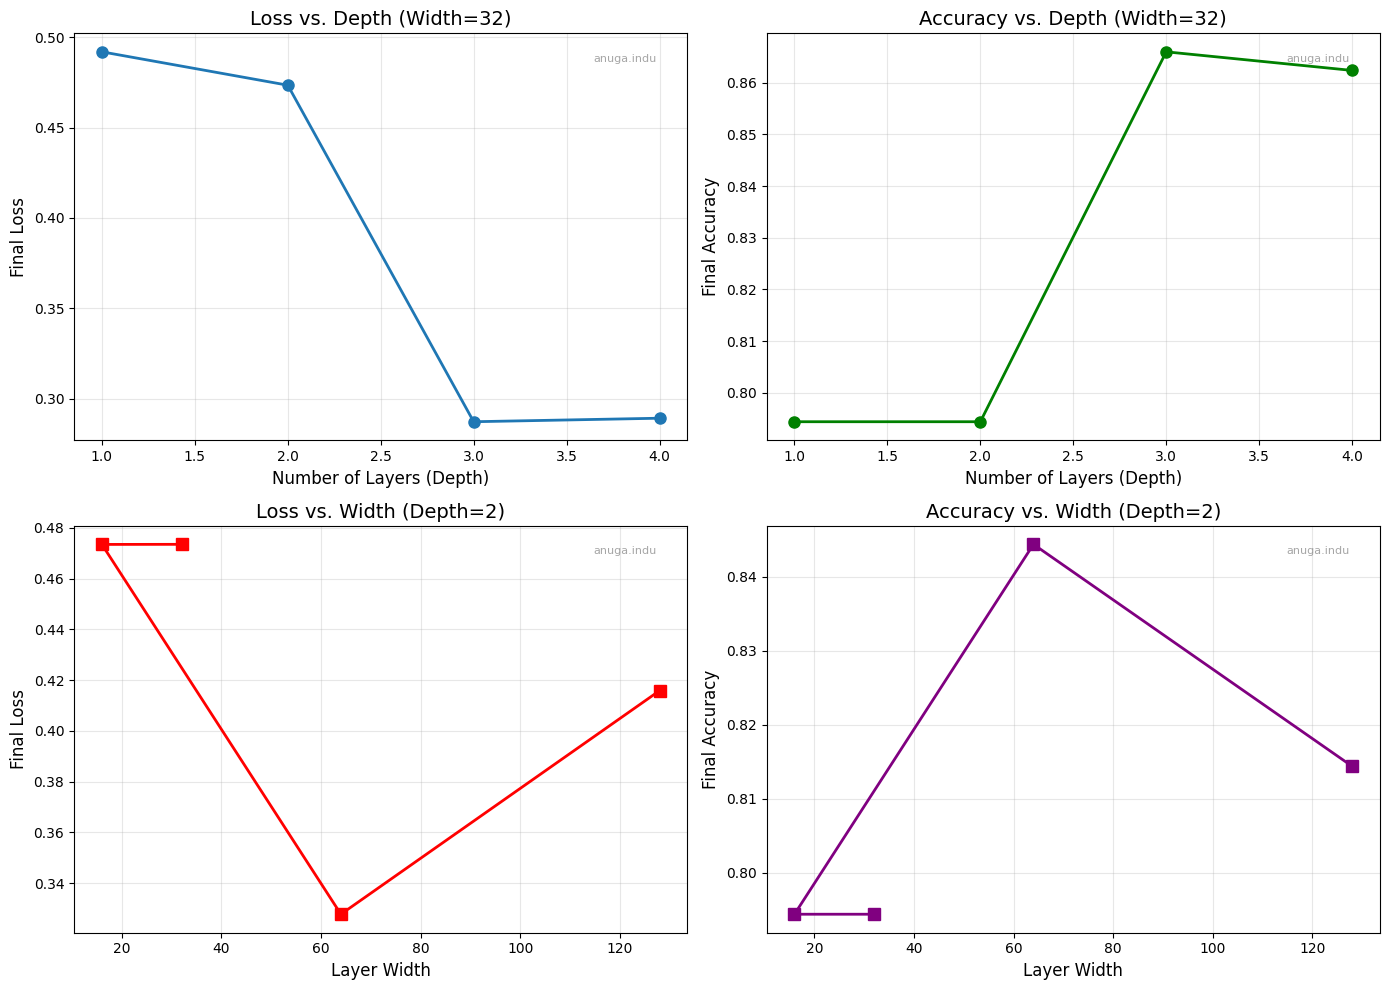

Depth/Width analysis plot saved to: runs/depth_width_analysis.png

Hyperparameter Tuning


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 21!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233223
   - Loss plot: runs/20251015_233223\training_loss.png
   - Model parameters: runs/20251015_233223\model_params.npz
Visualization saved to: runs/map_20251015_233223_LR_0.001\prediction_visualization.png
Errors: 514 pixels (20.56%)

Model: LR_0.001
Final Accuracy: 0.7944 (79.44%)
Final Loss: 0.518046
Epochs: 21
Training Time: 0.58 seconds
Total Samples Seen: 52416
Results saved to: runs/map_20251015_233223_LR_0.001


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 81!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233224
   - Loss plot: runs/20251015_233224\training_loss.png
   - Model parameters: runs/20251015_233224\model_params.npz
Visualization saved to: runs/map_20251015_233224_LR_0.01\prediction_visualization.png
Errors: 458 pixels (18.32%)

Model: LR_0.01
Final Accuracy: 0.8168 (81.68%)
Final Loss: 0.421793
Epochs: 81
Training Time: 1.89 seconds
Total Samples Seen: 202176
Results saved to: runs/map_20251015_233224_LR_0.01


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 83!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233226
   - Loss plot: runs/20251015_233226\training_loss.png
   - Model parameters: runs/20251015_233226\model_params.npz
Visualization saved to: runs/map_20251015_233226_LR_0.05\prediction_visualization.png
Errors: 353 pixels (14.12%)

Model: LR_0.05
Final Accuracy: 0.8588 (85.88%)
Final Loss: 0.304668
Epochs: 83
Training Time: 1.66 seconds
Total Samples Seen: 207168
Results saved to: runs/map_20251015_233226_LR_0.05


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 194!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233228
   - Loss plot: runs/20251015_233228\training_loss.png
   - Model parameters: runs/20251015_233228\model_params.npz
Visualization saved to: runs/map_20251015_233228_BS_32\prediction_visualization.png
Errors: 346 pixels (13.84%)

Model: BS_32
Final Accuracy: 0.8616 (86.16%)
Final Loss: 0.285747
Epochs: 194
Training Time: 5.31 seconds
Total Samples Seen: 484224
Results saved to: runs/map_20251015_233228_BS_32


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 49!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233234
   - Loss plot: runs/20251015_233234\training_loss.png
   - Model parameters: runs/20251015_233234\model_params.npz
Visualization saved to: runs/map_20251015_233234_BS_128\prediction_visualization.png
Errors: 514 pixels (20.56%)

Model: BS_128
Final Accuracy: 0.7944 (79.44%)
Final Loss: 0.451626
Epochs: 49
Training Time: 1.52 seconds
Total Samples Seen: 119168
Results saved to: runs/map_20251015_233234_BS_128


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 69!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233236
   - Loss plot: runs/20251015_233236\training_loss.png
   - Model parameters: runs/20251015_233236\model_params.npz
Visualization saved to: runs/map_20251015_233236_GradAccum_2\prediction_visualization.png
Errors: 516 pixels (20.64%)

Model: GradAccum_2
Final Accuracy: 0.7936 (79.36%)
Final Loss: 0.446002
Epochs: 69
Training Time: 1.23 seconds
Total Samples Seen: 172224
Results saved to: runs/map_20251015_233236_GradAccum_2


Starting training for up to 500 epochs (early stopping enabled)...



Early stopping triggered at epoch 117!
Loss improvement < 1.0% over last 10 epochs.

Training complete! Results saved in folder: runs/20251015_233237
   - Loss plot: runs/20251015_233237\training_loss.png
   - Model parameters: runs/20251015_233237\model_params.npz
Visualization saved to: runs/map_20251015_233237_GradAccum_4\prediction_visualization.png
Errors: 420 pixels (16.80%)

Model: GradAccum_4
Final Accuracy: 0.8320 (83.20%)
Final Loss: 0.389804
Epochs: 117
Training Time: 1.85 seconds
Total Samples Seen: 292032
Results saved to: runs/map_20251015_233237_GradAccum_4



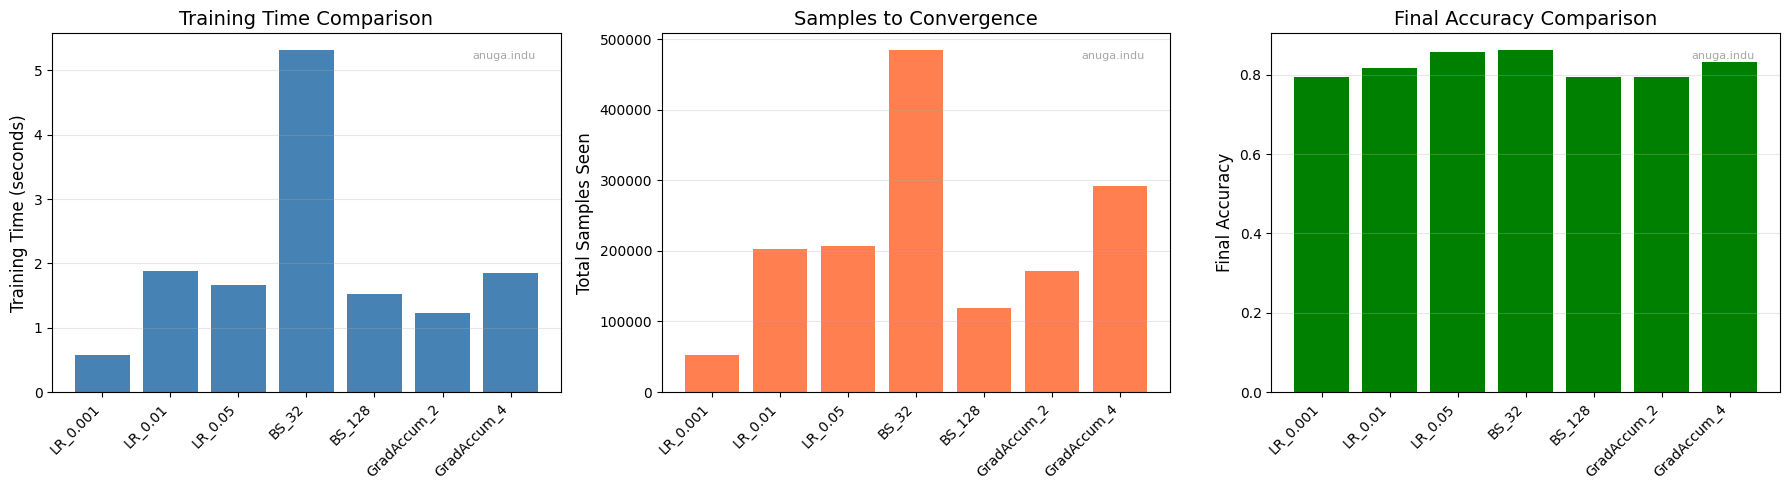

Hyperparameter comparison plot saved to: runs/hyperparameter_comparison.png


In [94]:
def calculate_accuracy(model, dataset):
    """
    Calculate accuracy on the full dataset.
    """
    correct = 0
    samples = dataset.get_all_samples(shuffle=False)
    
    X = np.array([p[0] for p in samples])
    y = np.array([p[1] for p in samples])
    
    predictions = model.predict(X)
    pred_classes = (predictions > 0.5).astype(int).flatten()
    
    correct = np.sum(pred_classes == y)
    return correct / len(samples)


# def visualize_predictions0(model, dataset, mask, run_dir, model_name):
#     """
#     Creates side-by-side visualization:
#     1. Ground truth map
#     2. Predicted map
#     3. Error map (misclassified pixels)
#     """
#     h, w = mask.shape
#     samples = dataset.get_all_samples(shuffle=False)
    
#     # Get all predictions
#     X = np.array([p[0] for p in samples])
#     predictions = model.predict(X)
#     pred_classes = (predictions > 0.5).astype(int).flatten()
    
#     # Reshape predictions to image shape
#     pred_map = np.zeros((h, w))
#     true_map = np.zeros((h, w))
    
#     for i, ((x_norm, y_norm), label) in enumerate(samples):
#         x_pixel = int(round(x_norm * (w - 1)))
#         y_pixel = int(round(y_norm * (h - 1)))
#         pred_map[y_pixel, x_pixel] = pred_classes[i]
#         true_map[y_pixel, x_pixel] = label
    
#     # Create error map
#     error_map = (pred_map != true_map).astype(int)
    
#     # Plot side-by-side
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
#     # Ground Truth Map
#     axes[0].imshow(true_map, cmap='RdYlBu', vmin=0, vmax=1)
#     axes[0].set_title('Ground Truth Map')
#     axes[0].axis('off')
    
#     # Predicted Map
#     axes[1].imshow(pred_map, cmap='RdYlBu', vmin=0, vmax=1)
#     axes[1].set_title('Predicted Map')
#     axes[1].axis('off')
    
#     # Error map overlay on ground truth
#     axes[2].imshow(true_map, cmap='RdYlBu', vmin=0, vmax=1, alpha=0.5)
#     axes[2].imshow(error_map, cmap='Reds', alpha=0.5)
#     axes[2].set_title('Error Map (Red = Misclassified)')
    

#     axes[2].axis('off')
    
#     plt.suptitle(f'{model_name}', fontsize=14)
#     plt.tight_layout()
    
#     save_path = os.path.join(run_dir, 'prediction_visualization.png')
#     plt.savefig(save_path, dpi=150, bbox_inches='tight')
#     plt.close()
    
#     print(f"Visualization saved to: {save_path}")
#     return pred_map, error_map


def visualize_predictions(model, dataset, mask, run_dir, model_name):
    """
    Creates side-by-side visualization:
    1. Ground truth map
    2. Predicted map
    3. Error map (misclassified pixels overlaid on ground truth)
    """
    h, w = mask.shape
    samples = dataset.get_all_samples(shuffle=False)
    
    # Get all predictions
    X = np.array([p[0] for p in samples])
    predictions = model.predict(X)
    pred_classes = (predictions > 0.5).astype(int).flatten()
    
    # Reshape predictions to image shape
    pred_map = np.zeros((h, w))
    true_map = np.zeros((h, w))
    
    for i, ((x_norm, y_norm), label) in enumerate(samples):
        x_pixel = int(round(x_norm * (w - 1)))
        y_pixel = int(round(y_norm * (h - 1)))
        pred_map[y_pixel, x_pixel] = pred_classes[i]
        true_map[y_pixel, x_pixel] = label
    
    # Create error map
    error_map = (pred_map != true_map).astype(int)
    
    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Ground truth
    axes[0].imshow(true_map, cmap='RdYlBu', vmin=0, vmax=1)
    axes[0].set_title('Ground Truth Map', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    axes[0].text(0.95, 0.05, "anuga.indu", ha='right', va='bottom',
             transform=axes[0].transAxes, fontsize=8, color='white', alpha=0.7)

    
    # Predicted map
    axes[1].imshow(pred_map, cmap='RdYlBu', vmin=0, vmax=1)
    axes[1].set_title('Predicted Map', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    axes[1].text(0.95, 0.05, "anuga.indu", ha='right', va='bottom',
             transform=axes[1].transAxes, fontsize=8, color='white', alpha=0.7)

    
    # Error map - Overlay on ground truth
    axes[2].imshow(true_map, cmap='RdYlBu', vmin=0, vmax=1)
    
    # Create masked array to show only errors
    error_overlay = np.ma.masked_where(error_map == 0, error_map)
    axes[2].imshow(error_overlay, cmap='spring', alpha=0.8, vmin=0, vmax=1, interpolation='nearest')
    axes[2].set_title('Error Map (Yellow = Misclassified)', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    axes[2].text(0.95, 0.05, "anuga.indu", ha='right', va='bottom',
             transform=axes[2].transAxes, fontsize=8, color='white', alpha=0.7)
    
    # Calculate accuracy
    accuracy = 1 - (np.sum(error_map) / (h * w))
    num_errors = np.sum(error_map)
    
    plt.suptitle(f'{model_name}\nAccuracy: {accuracy:.2%} | Errors: {num_errors}/{h*w} pixels', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    save_path = os.path.join(run_dir, 'prediction_visualization.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Visualization saved to: {save_path}")
    print(f"Errors: {num_errors} pixels ({(1-accuracy)*100:.2f}%)")
    return pred_map, error_map



def train_and_evaluate_model(model, dataset, mask, model_name, 
                             num_epochs=500, batch_size=32, 
                             grad_accum_steps=1, patience=10, 
                             relative_loss_threshold=0.01):
    """
    Trains a model and evaluates it, saving all results.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = f"runs/map_{timestamp}_{model_name.replace(' ', '_')}"
    os.makedirs(run_dir, exist_ok=True)
    
    start_time = time.time()
    
    # Train model
    losses, samples_seen, epoch_losses = train_model2(
        model=model,
        dataset=dataset,
        num_epochs=num_epochs,
        batch_size=batch_size,
        grad_accum_steps=grad_accum_steps,
        patience=patience,
        relative_loss_threshold=relative_loss_threshold
    )
    
    training_time = time.time() - start_time
    
    # Calculate final metrics
    final_accuracy = calculate_accuracy(model, dataset)
    final_loss = epoch_losses[-1]
    total_samples_seen = samples_seen[-1]
    
    # Create visualizations
    pred_map, error_map = visualize_predictions(model, dataset, mask, run_dir, model_name)
    
    # Save metrics
    metrics = {
        'model_name': model_name,
        'final_accuracy': float(final_accuracy),
        'final_loss': float(final_loss),
        'epochs': len(epoch_losses),
        'total_samples_seen': int(total_samples_seen),
        'training_time_seconds': float(training_time),
        'batch_size': batch_size,
        'grad_accum_steps': grad_accum_steps,
        'patience': patience,
        'relative_loss_threshold': relative_loss_threshold
    }
    
    with open(os.path.join(run_dir, 'metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=4)
    
    print(f"\n{'='*70}")
    print(f"Model: {model_name}")
    print(f"Final Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    print(f"Final Loss: {final_loss:.6f}")
    print(f"Epochs: {len(epoch_losses)}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Total Samples Seen: {total_samples_seen}")
    print(f"Results saved to: {run_dir}")
    print(f"{'='*70}\n")
    
    return metrics


# ============================================================================
# 1. Train multiple model architectures
# ============================================================================

def experiment_1_architecture_comparison():
    """
    Compare different architectures with various widths, depths, and activations.
    """
    print("\nArchitecture Comparison")
    print("="*70 + "\n")
    
    architectures = [
        # Vary depth (fixed width = 32)
        {"name": "Depth_1_Width_32", "hidden_sizes": [32], "hidden_activations": [ReLU()], "output_activation": Sigmoid()},
        {"name": "Depth_2_Width_32", "hidden_sizes": [32, 32], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid()},
        {"name": "Depth_3_Width_32", "hidden_sizes": [32, 32, 32], "hidden_activations": [ReLU(), ReLU(), ReLU()], "output_activation": Sigmoid()},
        {"name": "Depth_4_Width_32", "hidden_sizes": [32, 32, 32, 32], "hidden_activations": [ReLU(), ReLU(), ReLU(), ReLU()], "output_activation": Sigmoid()},
        
        # Vary width (fixed depth = 2)
        {"name": "Depth_2_Width_16", "hidden_sizes": [16, 16], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid()},
        {"name": "Depth_2_Width_64", "hidden_sizes": [64, 64], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid()},
        {"name": "Depth_2_Width_128", "hidden_sizes": [128, 128], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid()},
        
        # Different activation functions
        {"name": "Tanh_Activation", "hidden_sizes": [32, 32], "hidden_activations": [Tanh(), Tanh()], "output_activation": Sigmoid()},
        {"name": "Sigmoid_Activation", "hidden_sizes": [32, 32], "hidden_activations": [Sigmoid(), Sigmoid()], "output_activation": Sigmoid()},
    ]
    
    results = []
    
    for arch in architectures:
        layers = []
        input_size = 2
        
        for i, hidden_size in enumerate(arch['hidden_sizes']):
            activation = arch['hidden_activations'][i]
            layers.append(LinearLayer(input_size, hidden_size, activation))
            input_size = hidden_size
        
        layers.append(LinearLayer(input_size, 1, arch['output_activation']))
        
        model = Model(layers, loss_type='BCE', lr=0.01)
        
        metrics = train_and_evaluate_model(
            model=model,
            dataset=dataset,
            mask=mask,
            model_name=arch['name'],
            num_epochs=500,
            batch_size=64,
            grad_accum_steps=1,
            patience=10,
            relative_loss_threshold=0.01
        )
        
        results.append(metrics)
    
    return results


# ============================================================================
# 2. Plot results as function of depth and width
# ============================================================================

def plot_depth_width_analysis(results):
    """
    Plot final loss and accuracy as a function of depth and width.
    """
    # Separate results by experiment type
    depth_results = [r for r in results if 'Depth' in r['model_name'] and 'Width_32' in r['model_name']]
    width_results = [r for r in results if 'Depth_2' in r['model_name'] and 'Width' in r['model_name']]
    
    # Extract depth values
    depths = [int(r['model_name'].split('_')[1]) for r in depth_results]
    depth_losses = [r['final_loss'] for r in depth_results]
    depth_accuracies = [r['final_accuracy'] for r in depth_results]
    
    # Extract width values
    widths = [int(r['model_name'].split('_')[3]) for r in width_results]
    width_losses = [r['final_loss'] for r in width_results]
    width_accuracies = [r['final_accuracy'] for r in width_results]
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Depth vs Loss
    axes[0, 0].plot(depths, depth_losses, 'o-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Number of Layers (Depth)', fontsize=12)
    axes[0, 0].set_ylabel('Final Loss', fontsize=12)
    axes[0, 0].set_title('Loss vs. Depth (Width=32)', fontsize=14)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].text(0.95, 0.95, "anuga.indu", ha='right', va='top',
                transform=axes[0, 0].transAxes, fontsize=8, color='gray', alpha=0.7)
    
    # Depth vs Accuracy
    axes[0, 1].plot(depths, depth_accuracies, 'o-', linewidth=2, markersize=8, color='green')
    axes[0, 1].set_xlabel('Number of Layers (Depth)', fontsize=12)
    axes[0, 1].set_ylabel('Final Accuracy', fontsize=12)
    axes[0, 1].set_title('Accuracy vs. Depth (Width=32)', fontsize=14)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].text(0.95, 0.95, "anuga.indu", ha='right', va='top',
                transform=axes[0, 1].transAxes, fontsize=8, color='gray', alpha=0.7)

    # Width vs Loss
    axes[1, 0].plot(widths, width_losses, 's-', linewidth=2, markersize=8, color='red')
    axes[1, 0].set_xlabel('Layer Width', fontsize=12)
    axes[1, 0].set_ylabel('Final Loss', fontsize=12)
    axes[1, 0].set_title('Loss vs. Width (Depth=2)', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].text(0.95, 0.95, "anuga.indu", ha='right', va='top',
                transform=axes[1, 0].transAxes, fontsize=8, color='gray', alpha=0.7)
    
    # Width vs Accuracy
    axes[1, 1].plot(widths, width_accuracies, 's-', linewidth=2, markersize=8, color='purple')
    axes[1, 1].set_xlabel('Layer Width', fontsize=12)
    axes[1, 1].set_ylabel('Final Accuracy', fontsize=12)
    axes[1, 1].set_title('Accuracy vs. Width (Depth=2)', fontsize=14)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].text(0.95, 0.95, "anuga.indu", ha='right', va='top',
                transform=axes[1, 1].transAxes, fontsize=8, color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('runs/depth_width_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Depth/Width analysis plot saved to: runs/depth_width_analysis.png")


# ============================================================================
# 3. Hyperparameter experiments
# ============================================================================

def experiment_2_hyperparameter_tuning():
    """
    Compare different hyperparameter settings.
    """
    print("\nHyperparameter Tuning")
    print("="*70 + "\n")
    
    hyperparams = [
        {"name": "LR_0.001", "lr": 0.001, "batch_size": 64, "grad_accum_steps": 1},
        {"name": "LR_0.01", "lr": 0.01, "batch_size": 64, "grad_accum_steps": 1},
        {"name": "LR_0.05", "lr": 0.05, "batch_size": 64, "grad_accum_steps": 1},
        {"name": "BS_32", "lr": 0.01, "batch_size": 32, "grad_accum_steps": 1},
        {"name": "BS_128", "lr": 0.01, "batch_size": 128, "grad_accum_steps": 1},
        {"name": "GradAccum_2", "lr": 0.01, "batch_size": 64, "grad_accum_steps": 2},
        {"name": "GradAccum_4", "lr": 0.01, "batch_size": 64, "grad_accum_steps": 4},
    ]
    
    results = []
    
    for hp in hyperparams:
        layers = [
            LinearLayer(2, 64, ReLU()),
            LinearLayer(64, 64, ReLU()),
            LinearLayer(64, 1, Sigmoid())
        ]
        
        model = Model(layers, loss_type='BCE', lr=hp['lr'])
        
        metrics = train_and_evaluate_model(
            model=model,
            dataset=dataset,
            mask=mask,
            model_name=hp['name'],
            num_epochs=500,
            batch_size=hp['batch_size'],
            grad_accum_steps=hp['grad_accum_steps'],
            patience=10,
            relative_loss_threshold=0.01
        )
        
        results.append(metrics)
    
    return results


def plot_hyperparameter_comparison(results):
    """
    Plot comparison of convergence time and samples needed.
    """
    names = [r['model_name'] for r in results]
    times = [r['training_time_seconds'] for r in results]
    samples = [r['total_samples_seen'] for r in results]
    accuracies = [r['final_accuracy'] for r in results]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Training time
    axes[0].bar(range(len(names)), times, color='steelblue')
    axes[0].set_xticks(range(len(names)))
    axes[0].set_xticklabels(names, rotation=45, ha='right')
    axes[0].set_ylabel('Training Time (seconds)', fontsize=12)
    axes[0].set_title('Training Time Comparison', fontsize=14)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].text(0.95, 0.95, "anuga.indu", ha='right', va='top',
             transform=axes[0].transAxes, fontsize=8, color='gray', alpha=0.7)
    
    # Samples to converge
    axes[1].bar(range(len(names)), samples, color='coral')
    axes[1].set_xticks(range(len(names)))
    axes[1].set_xticklabels(names, rotation=45, ha='right')
    axes[1].set_ylabel('Total Samples Seen', fontsize=12)
    axes[1].set_title('Samples to Convergence', fontsize=14)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].text(0.95, 0.95, "anuga.indu", ha='right', va='top',
             transform=axes[1].transAxes, fontsize=8, color='gray', alpha=0.7)

    # Final accuracy
    axes[2].bar(range(len(names)), accuracies, color='green')
    axes[2].set_xticks(range(len(names)))
    axes[2].set_xticklabels(names, rotation=45, ha='right')
    axes[2].set_ylabel('Final Accuracy', fontsize=12)
    axes[2].set_title('Final Accuracy Comparison', fontsize=14)
    axes[2].grid(axis='y', alpha=0.3)
    axes[2].text(0.95, 0.95, "anuga.indu", ha='right', va='top',
             transform=axes[2].transAxes, fontsize=8, color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('runs/hyperparameter_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Hyperparameter comparison plot saved to: runs/hyperparameter_comparison.png")



# Experiment 1: Architecture comparison
results_arch = experiment_1_architecture_comparison()

# Plot depth/width analysis
plot_depth_width_analysis(results_arch)

# Experiment 2: Hyperparameter tuning
results_hyper = experiment_2_hyperparameter_tuning()

# Plot hyperparameter comparison
plot_hyperparameter_comparison(results_hyper)


# # Print summary table
# print("\nFINAL SUMMARY")
# print("="*70 + "\n")
# all_results = results_arch + results_hyper
# table_data = []
# for idx, r in enumerate(all_results, 1):
#     table_data.append([
#         idx,
#         r['model_name'],
#         f"{r['final_accuracy']:.4f}",
#         f"{r['final_loss']:.6f}",
#         r['epochs'],
#         f"{r['training_time_seconds']:.2f}s",
#         r['total_samples_seen']
#     ])
# headers = ["#", "Model", "Accuracy", "Final Loss", "Epochs", "Time", "Samples"]
# print(tabulate(table_data, headers=headers, tablefmt="grid"))

## 1.5 Final Challenge

In [95]:
# ============================================================================
# GOAL 1: Minimize Model Size (Minimum Parameters for 91% Accuracy)
# ============================================================================

def count_parameters(layers):
    """Count total number of trainable parameters in the model."""
    total_params = 0
    for layer in layers:
        # Parameters in weights: in_features × out_features
        # Parameters in biases: out_features
        total_params += layer.W.size + layer.b.size
    return total_params


def create_model_by_architecture(architecture):
    """
    Creates a model from architecture specification.
    Args:
        architecture: dict with 'hidden_sizes', 'hidden_activations', 'output_activation', 'lr'
    Returns:
        model, param_count
    """
    layers = []
    input_size = 2
    
    for i, hidden_size in enumerate(architecture['hidden_sizes']):
        activation = architecture['hidden_activations'][i]
        layers.append(LinearLayer(input_size, hidden_size, activation))
        input_size = hidden_size
    
    layers.append(LinearLayer(input_size, 1, architecture['output_activation']))
    
    model = Model(layers, loss_type='BCE', lr=architecture.get('lr', 0.01))
    param_count = count_parameters(layers)
    
    return model, param_count



def goal1_minimize_parameters():
    """
    Goal 1: Find the smallest model that achieves 91% accuracy.
    """
    print("\n" + "="*80)
    print("GOAL 1: MINIMIZE MODEL SIZE (Target: 91% Accuracy)")
    print("="*80 + "\n")
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    goal1_main_dir = f"runs/goal1_{timestamp}"
    os.makedirs(goal1_main_dir, exist_ok=True)
    print(f"Results will be saved in: {goal1_main_dir}\n")
    
    # Architecture search from smallest to largest
    # architectures = [
    #     # Ultra-minimal architectures (< 50 params)
    #     {"name": "Tiny_4", "hidden_sizes": [4], "hidden_activations": [ReLU()], "output_activation": Sigmoid(), "lr": 0.02},
    #     {"name": "Tiny_6", "hidden_sizes": [6], "hidden_activations": [ReLU()], "output_activation": Sigmoid(), "lr": 0.02},
    #     {"name": "Tiny_8", "hidden_sizes": [8], "hidden_activations": [ReLU()], "output_activation": Sigmoid(), "lr": 0.02},
        
    #     # Small architectures (50-150 params)
    #     {"name": "Small_12", "hidden_sizes": [12], "hidden_activations": [ReLU()], "output_activation": Sigmoid(), "lr": 0.01},
    #     {"name": "Small_16", "hidden_sizes": [16], "hidden_activations": [ReLU()], "output_activation": Sigmoid(), "lr": 0.01},
    #     {"name": "Small_6_4", "hidden_sizes": [6, 4], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.01},
    #     {"name": "Small_8_4", "hidden_sizes": [8, 4], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.01},
        
    #     # Medium architectures (150-400 params)
    #     {"name": "Med_20", "hidden_sizes": [20], "hidden_activations": [ReLU()], "output_activation": Sigmoid(), "lr": 0.01},
    #     {"name": "Med_12_8", "hidden_sizes": [12, 8], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.01},
    #     {"name": "Med_16_8", "hidden_sizes": [16, 8], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.01},
        
    #     # Alternate activations (for comparison)
    #     {"name": "Tanh_12_8", "hidden_sizes": [12, 8], "hidden_activations": [Tanh(), Tanh()], "output_activation": Sigmoid(), "lr": 0.01},
    #     {"name": "Mixed_16_8", "hidden_sizes": [16, 8], "hidden_activations": [Tanh(), ReLU()], "output_activation": Sigmoid(), "lr": 0.01},
    # ]

    architectures = [
        # Two-layer with good capacity
        {"name": "Small_20_12", "hidden_sizes": [20, 12], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.015},
        {"name": "Small_24_16", "hidden_sizes": [24, 16], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.012},
        {"name": "Small_28_14", "hidden_sizes": [28, 14], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.012},
        
        # === MEDIUM ARCHITECTURES (Sweet Spot) ===
        {"name": "Med_32_16", "hidden_sizes": [32, 16], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.010},
        {"name": "Med_40_20", "hidden_sizes": [40, 20], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.010},
        {"name": "Med_48_24", "hidden_sizes": [48, 24], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.008},
        {"name": "Med_56_28", "hidden_sizes": [56, 28], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.008},
        
        # === THREE-LAYER DEEP NETWORKS ===
        {"name": "Deep_32_24_12", "hidden_sizes": [32, 24, 12], "hidden_activations": [ReLU(), ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.008},
        {"name": "Deep_40_30_15", "hidden_sizes": [40, 30, 15], "hidden_activations": [ReLU(), ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.008},
        {"name": "Deep_48_36_18", "hidden_sizes": [48, 36, 18], "hidden_activations": [ReLU(), ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.006},
        
        # === TANH VARIATIONS (Sometimes better for borders) ===
        {"name": "Tanh_32_16", "hidden_sizes": [32, 16], "hidden_activations": [Tanh(), Tanh()], "output_activation": Sigmoid(), "lr": 0.012},
        {"name": "Tanh_40_20", "hidden_sizes": [40, 20], "hidden_activations": [Tanh(), Tanh()], "output_activation": Sigmoid(), "lr": 0.010},
        {"name": "Tanh_48_32_16", "hidden_sizes": [48, 32, 16], "hidden_activations": [Tanh(), Tanh(), Tanh()], "output_activation": Sigmoid(), "lr": 0.008},
        
        # === MIXED ACTIVATIONS (Best of both worlds) ===
        {"name": "Mixed_ReLU_Tanh_32_16", "hidden_sizes": [32, 16], "hidden_activations": [ReLU(), Tanh()], "output_activation": Sigmoid(), "lr": 0.02},
        {"name": "Mixed_Tanh_ReLU_40_20", "hidden_sizes": [40, 20], "hidden_activations": [Tanh(), ReLU()], "output_activation": Sigmoid(), "lr": 0.010},
        
        # === WIDE NETWORKS (More parameters) ===
        {"name": "Deep_64_32_16", "hidden_sizes": [64, 32, 16], "hidden_activations": [ReLU(), ReLU(), Tanh()], "output_activation": Sigmoid(), "lr": 0.2},
        
        {"name": "Wide_64_32", "hidden_sizes": [64, 32], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.006},
        {"name": "Wide_80_40", "hidden_sizes": [80, 40], "hidden_activations": [ReLU(), ReLU()], "output_activation": Sigmoid(), "lr": 0.005},
    ]
    
    results = []
    best_model = None
    best_params = float('inf')
    best_arch_name = None
    
    for arch in architectures:
        print(f"\n{'='*70}")
        print(f"Testing Architecture: {arch['name']}")
        
        model, param_count = create_model_by_architecture(arch)
        print(f"Parameters: {param_count}")
        
        # Create subdirectory for this architecture 
        arch_run_dir = os.path.join(goal1_main_dir, arch['name'])
        os.makedirs(arch_run_dir, exist_ok=True)
        
        # Train model using train_with_accuracy_tracking
        metrics = train_with_accuracy_tracking(
            model=model,
            dataset=dataset,
            mask=mask,
            model_name=arch['name'],
            run_dir=arch_run_dir,  # Pass the subdirectory
            num_epochs=2000,
            batch_size=64,
            grad_accum_steps=1,
            patience=50,
            relative_loss_threshold=0.001
        )
        
        metrics['param_count'] = param_count
        metrics['architecture'] = arch['name']
        results.append(metrics)
        
        # Check if this is our best model so far
        if metrics['final_accuracy'] >= 0.91 and param_count < best_params:
            best_params = param_count
            best_model = model
            best_arch_name = arch['name']
            print(f"\n NEW BEST: {arch['name']} with {param_count} params @ {metrics['final_accuracy']:.4f} accuracy!")
    
    # Print results table
    print("\n" + "="*80)
    print("GOAL 1 RESULTS SUMMARY")
    print("="*80 + "\n")
    
    table_data = []
    for r in sorted(results, key=lambda x: x['param_count']):
        achieved = "✓" if r['final_accuracy'] >= 0.91 else "✗"
        table_data.append([
            r['architecture'],
            r['param_count'],
            f"{r['final_accuracy']:.4f}",
            f"{r['final_loss']:.6f}",
            r['epochs'],
            achieved
        ])
    
    headers = ["Architecture", "Parameters", "Accuracy", "Loss", "Epochs", "≥91%"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
    # Save summary JSON
    with open(os.path.join(goal1_main_dir, 'summary.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Create comparison plot
    plot_goal1_comparison(results, goal1_main_dir)
    
    if best_model:
        print(f"\n{'='*80}")
        print(f" OPTIMAL MODEL FOR GOAL 1: {best_arch_name}")
        print(f"   Parameters: {best_params}")
        print(f"   Accuracy: {[r for r in results if r['architecture'] == best_arch_name][0]['final_accuracy']:.4f}")
        print(f"   Results saved in: {goal1_main_dir}")
        print(f"{'='*80}\n")
    else:
        print(f"\n No model achieved 91% accuracy.")
        print(f"   Results saved in: {goal1_main_dir}\n")
    
    return results, best_model, best_arch_name


def train_with_accuracy_tracking(
    model,
    dataset,
    mask,
    model_name,
    run_dir,
    num_epochs=1000,
    batch_size=64,
    grad_accum_steps=1,
    patience=20,
    relative_loss_threshold=0.005
):
    """
    Train model and save results in the provided run_dir.
    Similar to train_and_evaluate_model but uses pre-created directory.
    """
    start_time = time.time()
    
    # Train model
    losses, samples_seen, epoch_losses = train_model2(
        model=model,
        dataset=dataset,
        num_epochs=num_epochs,
        batch_size=batch_size,
        grad_accum_steps=grad_accum_steps,
        patience=patience,
        relative_loss_threshold=relative_loss_threshold
    )
    
    training_time = time.time() - start_time
    
    # Calculate final metrics
    final_accuracy = calculate_accuracy(model, dataset)
    final_loss = epoch_losses[-1] if epoch_losses else float('inf')
    total_samples_seen = samples_seen[-1] if samples_seen else 0
    
    # Create visualizations
    pred_map, error_map = visualize_predictions(model, dataset, mask, run_dir, model_name)
    
    # Save training loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(samples_seen, losses, label='Training Loss', alpha=0.7)
    plt.xlabel("Samples Seen")
    plt.ylabel("Loss")
    plt.title(f"Training Loss - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.text(0.95, 0.95, "anuga.indu", ha='right', va='top',
         transform=plt.gca().transAxes, fontsize=10, color='gray', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, "training_loss.png"), dpi=150)
    plt.close()
    
    # Save model
    model.save_to(os.path.join(run_dir, "model_params.npz"))
    
    # Save metrics
    metrics = {
        'model_name': model_name,
        'final_accuracy': float(final_accuracy),
        'final_loss': float(final_loss),
        'epochs': len(epoch_losses),
        'total_samples_seen': int(total_samples_seen),
        'training_time_seconds': float(training_time),
        'batch_size': batch_size,
        'grad_accum_steps': grad_accum_steps,
        'patience': patience,
        'relative_loss_threshold': relative_loss_threshold
    }
    
    with open(os.path.join(run_dir, 'metrics.json'), 'w') as f:
        json.dump(metrics, f, indent=4)
    
    print(f"\n{'='*70}")
    print(f"Model: {model_name}")
    print(f"Final Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
    print(f"Final Loss: {final_loss:.6f}")
    print(f"Epochs: {len(epoch_losses)}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Results saved to: {run_dir}")
    print(f"{'='*70}\n")
    
    return metrics


def plot_goal1_comparison(results, save_dir):
    """Create comparison plots for Goal 1 results."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Sort by parameters
    sorted_results = sorted(results, key=lambda x: x['param_count'])
    params = [r['param_count'] for r in sorted_results]
    accs = [r['final_accuracy'] for r in sorted_results]
    names = [r['architecture'] for r in sorted_results]
    
    # Plot 1: Accuracy vs Parameters
    colors = ['green' if acc >= 0.91 else 'red' for acc in accs]
    axes[0].scatter(params, accs, c=colors, s=100, alpha=0.6)
    axes[0].axhline(y=0.91, color='blue', linestyle='--', label='Target (91%)')
    axes[0].set_xlabel('Number of Parameters', fontsize=12)
    axes[0].set_ylabel('Final Accuracy', fontsize=12)
    axes[0].set_title('Accuracy vs Model Size', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].text(0.95, 0.95, "anuga.indu", ha='right', va='top',
             transform=axes[0].transAxes, fontsize=8, color='gray', alpha=0.7)

    # Plot 2: Bar chart of accuracies
    bar_colors = ['green' if acc >= 0.91 else 'coral' for acc in accs]
    axes[1].barh(range(len(names)), accs, color=bar_colors)
    axes[1].set_yticks(range(len(names)))
    axes[1].set_yticklabels(names, fontsize=9)
    axes[1].axvline(x=0.91, color='blue', linestyle='--', label='Target (91%)')
    axes[1].set_xlabel('Final Accuracy', fontsize=12)
    axes[1].set_title('Architecture Comparison', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='x')
    axes[1].text(0.95, 0.95, "anuga.indu", ha='right', va='top',
             transform=axes[1].transAxes, fontsize=8, color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'goal1_comparison.png'), dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Comparison plot saved: {os.path.join(save_dir, 'goal1_comparison.png')}")



# ============================================================================
# GOAL 2: Minimize Training Samples (Minimum Samples for 91% Accuracy)
# ============================================================================

def train_with_sample_tracking(
    model,
    dataset,
    target_accuracy=0.91,
    max_epochs=2000,
    batch_size=32,
    lr=0.01,
    check_interval=5,
    model_name="Goal2_Model"
):
    """
    Train model and track when target accuracy is first achieved.
    Returns detailed training history.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = f"runs/goal2_{timestamp}_{model_name}"
    os.makedirs(run_dir, exist_ok=True)
    
    all_samples = dataset.get_all_samples(shuffle=True)
    num_samples = len(all_samples)
    total_batches = num_samples // batch_size
    
    losses = []
    samples_seen = []
    accuracies = []
    accuracy_check_samples = []
    
    target_achieved = False
    samples_to_target = None
    epochs_to_target = None
    
    model.lr = lr  # Set learning rate
    
    print(f"\nTraining with LR={lr}, BS={batch_size}")
    print(f"Target: {target_accuracy:.2%} accuracy\n")
    
    start_time = time.time()
    
    for epoch in range(max_epochs):
        epoch_loss = 0.0
        all_samples = dataset.get_all_samples(shuffle=True)
        
        for i in range(total_batches):
            batch = all_samples[i * batch_size:(i + 1) * batch_size]
            
            X = np.array([p[0] for p in batch])
            y = np.array([[p[1]] for p in batch])
            
            loss = model.train(X, y)
            model.update()
            epoch_loss += loss
            
            current_samples = (epoch * total_batches + i + 1) * batch_size
            samples_seen.append(current_samples)
            losses.append(loss)
        
        # Check accuracy every few epochs
        if (epoch + 1) % check_interval == 0:
            current_accuracy = calculate_accuracy(model, dataset)
            accuracies.append(current_accuracy)
            accuracy_check_samples.append(samples_seen[-1])
            
            # print(f"Epoch {epoch+1:4d} | Samples: {samples_seen[-1]:7d} | Accuracy: {current_accuracy:.4f}")
            
            if not target_achieved and current_accuracy >= target_accuracy:
                target_achieved = True
                samples_to_target = samples_seen[-1]
                epochs_to_target = epoch + 1
                print(f"\n  TARGET ACHIEVED at epoch {epochs_to_target}!")
                print(f"   Samples needed: {samples_to_target}")
                print(f"   Accuracy: {current_accuracy:.4f}\n")
        
        # Early stopping if target achieved and stable
        if target_achieved and (epoch - epochs_to_target) > 20:
            print(f"Stopping - target maintained for 20 epochs")
            break
    
    training_time = time.time() - start_time
    final_accuracy = calculate_accuracy(model, dataset)
    
    # Save results
    results = {
        'model_name': model_name,
        'final_accuracy': float(final_accuracy),
        'target_accuracy': target_accuracy,
        'target_achieved': target_achieved,
        'samples_to_target': samples_to_target,
        'epochs_to_target': epochs_to_target,
        'total_epochs': epoch + 1,
        'batch_size': batch_size,
        'learning_rate': lr,
        'training_time': training_time
    }
    
    # Plot training progress
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    ax1.plot(samples_seen, losses, alpha=0.6, linewidth=0.5)
    ax1.set_xlabel('Samples Seen')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True, alpha=0.3)
    if samples_to_target:
        ax1.axvline(x=samples_to_target, color='red', linestyle='--', label=f'Target @ {samples_to_target} samples')
        ax1.legend()
    
    # Accuracy plot
    ax2.plot(accuracy_check_samples, accuracies, 'o-', linewidth=2, markersize=6)
    ax2.axhline(y=target_accuracy, color='green', linestyle='--', label=f'Target ({target_accuracy:.0%})')
    ax2.set_xlabel('Samples Seen')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Progress')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'training_progress.png'), dpi=150)
    plt.close()
    
    # Save metrics
    with open(os.path.join(run_dir, 'metrics.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Visualize predictions
    visualize_predictions(model, dataset, mask, run_dir, model_name)
    
    return results, model


def goal2_minimize_samples():
    """
    Goal 2: Find optimal hyperparameters to reach 91% with minimum samples.
    Strategy: Test different learning rates and batch sizes.
    """
    print("\n" + "="*80)
    print("GOAL 2: MINIMIZE TRAINING SAMPLES (Target: 91% Accuracy)")
    print("="*80 + "\n")
    
    # Use a reasonably-sized architecture (from Goal 1 insights)
    base_architecture = {
        "hidden_sizes": [16, 8],
        "hidden_activations": [ReLU(), ReLU()],
        "output_activation": Sigmoid()
    }
    
    # Hyperparameter combinations to test
    configs = [
        # Different learning rates (batch_size=64)
        {"name": "LR_0.001_BS_64", "lr": 0.001, "batch_size": 64},
        {"name": "LR_0.005_BS_64", "lr": 0.005, "batch_size": 64},
        {"name": "LR_0.01_BS_64", "lr": 0.01, "batch_size": 64},
        {"name": "LR_0.02_BS_64", "lr": 0.02, "batch_size": 64},
        {"name": "LR_0.05_BS_64", "lr": 0.05, "batch_size": 64},
        
        # Different batch sizes (lr=0.01)
        {"name": "LR_0.01_BS_32", "lr": 0.01, "batch_size": 32},
        {"name": "LR_0.01_BS_128", "lr": 0.01, "batch_size": 128},
        {"name": "LR_0.01_BS_256", "lr": 0.01, "batch_size": 256},
        
        # Aggressive configurations
        {"name": "LR_0.05_BS_32", "lr": 0.05, "batch_size": 32},
        {"name": "LR_0.02_BS_128", "lr": 0.02, "batch_size": 128},
        
        # Conservative configurations
        {"name": "LR_0.005_BS_128", "lr": 0.005, "batch_size": 128},
    ]
    
    results = []
    best_samples = float('inf')
    best_config = None
    best_model = None
    
    for config in configs:
        print(f"\n{'='*70}")
        print(f"Testing Configuration: {config['name']}")
        
        # Create fresh model
        model, param_count = create_model_by_architecture({
            **base_architecture,
            'lr': config['lr']
        })
        
        # Train and track
        result, trained_model = train_with_sample_tracking(
            model=model,
            dataset=dataset,
            target_accuracy=0.91,
            max_epochs=1500,
            batch_size=config['batch_size'],
            lr=config['lr'],
            check_interval=5,
            model_name=config['name']
        )
        
        results.append(result)
        
        # Track best configuration
        if result['target_achieved'] and result['samples_to_target'] < best_samples:
            best_samples = result['samples_to_target']
            best_config = config['name']
            best_model = trained_model
            print(f"\n NEW BEST: {config['name']} with {best_samples} samples!")
    
    # Print results table
    print("\n" + "="*80)
    print("GOAL 2 RESULTS SUMMARY")
    print("="*80 + "\n")
    
    table_data = []
    # FIXED: Sort with proper handling of None values
    sorted_results = sorted(results, key=lambda x: (x.get('samples_to_target') is None, x.get('samples_to_target', float('inf'))))
    
    for r in sorted_results:
        achieved = "✓" if r['target_achieved'] else "✗"
        samples = r['samples_to_target'] if r['target_achieved'] else "N/A"
        epochs = r['epochs_to_target'] if r['target_achieved'] else "N/A"
        
        table_data.append([
            r['model_name'],
            r['learning_rate'],
            r['batch_size'],
            samples,
            epochs,
            f"{r['final_accuracy']:.4f}",
            achieved
        ])
    
    headers = ["Configuration", "LR", "BS", "Samples", "Epochs", "Final Acc", "≥91%"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
    if best_config:
        print(f"\n{'='*80}")
        print(f" OPTIMAL CONFIGURATION FOR GOAL 2: {best_config}")
        print(f"   Minimum samples to 91%: {best_samples}")
        print(f"{'='*80}\n")
    
    return results, best_model, best_config



def run_final_challenge():    
    
    # Goal 1: Minimize Parameters
    goal1_results, goal1_best_model, goal1_best_arch = goal1_minimize_parameters()
    
    # Goal 2: Minimize Samples
    print("\n\n")
    goal2_results, goal2_best_model, goal2_best_config = goal2_minimize_samples()
    
    # Final Summary
    print("\n\n" + "="*80)
    print("FINAL CHALLENGE COMPLETE - SUMMARY")
    print("="*80 + "\n")
    
    print("GOAL 1 - Minimum Parameters:")
    if goal1_best_arch:
        best_g1 = [r for r in goal1_results if r['architecture'] == goal1_best_arch][0]
        print(f"  Architecture: {goal1_best_arch}")
        print(f"  Parameters: {best_g1['param_count']}")
        print(f"  Accuracy: {best_g1['final_accuracy']:.4f}")
    else:
        print("  No model achieved 91% accuracy")
    
    print("\nGOAL 2 - Minimum Samples:")
    if goal2_best_config:
        best_g2 = [r for r in goal2_results if r['model_name'] == goal2_best_config][0]
        print(f"  Configuration: {goal2_best_config}")
        print(f"  Samples to 91%: {best_g2['samples_to_target']}")
        print(f"  Final Accuracy: {best_g2['final_accuracy']:.4f}")
    else:
        print("  No configuration achieved 91% accuracy")
    

run_final_challenge()


GOAL 1: MINIMIZE MODEL SIZE (Target: 91% Accuracy)

Results will be saved in: runs/goal1_20251015_233240


Testing Architecture: Small_20_12
Parameters: 325

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 555!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233240
   - Loss plot: runs/20251015_233240\training_loss.png
   - Model parameters: runs/20251015_233240\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Small_20_12\prediction_visualization.png
Errors: 305 pixels (12.20%)

Model: Small_20_12
Final Accuracy: 0.8780 (87.80%)
Final Loss: 0.273364
Epochs: 555
Training Time: 6.40 seconds
Results saved to: runs/goal1_20251015_233240\Small_20_12


Testing Architecture: Small_24_16
Parameters: 489

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 1059!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233247
   - Loss plot: runs/20251015_233247\training_loss.png
   - Model parameters: runs/20251015_233247\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Small_24_16\prediction_visualization.png
Errors: 275 pixels (11.00%)

Model: Small_24_16
Final Accuracy: 0.8900 (89.00%)
Final Loss: 0.259633
Epochs: 1059
Training Time: 11.87 seconds
Results saved to: runs/goal1_20251015_233240\Small_24_16


Testing Architecture: Small_28_14
Parameters: 505

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 569!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233300
   - Loss plot: runs/20251015_233300\training_loss.png
   - Model parameters: runs/20251015_233300\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Small_28_14\prediction_visualization.png
Errors: 300 pixels (12.00%)

Model: Small_28_14
Final Accuracy: 0.8800 (88.00%)
Final Loss: 0.273268
Epochs: 569
Training Time: 6.96 seconds
Results saved to: runs/goal1_20251015_233240\Small_28_14


Testing Architecture: Med_32_16
Parameters: 641

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 667!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233308
   - Loss plot: runs/20251015_233308\training_loss.png
   - Model parameters: runs/20251015_233308\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Med_32_16\prediction_visualization.png
Errors: 298 pixels (11.92%)

Model: Med_32_16
Final Accuracy: 0.8808 (88.08%)
Final Loss: 0.270212
Epochs: 667
Training Time: 7.59 seconds
Results saved to: runs/goal1_20251015_233240\Med_32_16


Testing Architecture: Med_40_20
Parameters: 961

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 742!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233316
   - Loss plot: runs/20251015_233316\training_loss.png
   - Model parameters: runs/20251015_233316\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Med_40_20\prediction_visualization.png
Errors: 294 pixels (11.76%)

Model: Med_40_20
Final Accuracy: 0.8824 (88.24%)
Final Loss: 0.268416
Epochs: 742
Training Time: 9.68 seconds
Results saved to: runs/goal1_20251015_233240\Med_40_20


Testing Architecture: Med_48_24
Parameters: 1345

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 751!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233327
   - Loss plot: runs/20251015_233327\training_loss.png
   - Model parameters: runs/20251015_233327\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Med_48_24\prediction_visualization.png
Errors: 293 pixels (11.72%)

Model: Med_48_24
Final Accuracy: 0.8828 (88.28%)
Final Loss: 0.268285
Epochs: 751
Training Time: 10.15 seconds
Results saved to: runs/goal1_20251015_233240\Med_48_24


Testing Architecture: Med_56_28
Parameters: 1793

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 979!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233338
   - Loss plot: runs/20251015_233338\training_loss.png
   - Model parameters: runs/20251015_233338\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Med_56_28\prediction_visualization.png
Errors: 305 pixels (12.20%)

Model: Med_56_28
Final Accuracy: 0.8780 (87.80%)
Final Loss: 0.265248
Epochs: 979
Training Time: 16.03 seconds
Results saved to: runs/goal1_20251015_233240\Med_56_28


Testing Architecture: Deep_32_24_12
Parameters: 1201

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 547!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233355
   - Loss plot: runs/20251015_233355\training_loss.png
   - Model parameters: runs/20251015_233355\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Deep_32_24_12\prediction_visualization.png
Errors: 264 pixels (10.56%)

Model: Deep_32_24_12
Final Accuracy: 0.8944 (89.44%)
Final Loss: 0.250867
Epochs: 547
Training Time: 59.07 seconds
Results saved to: runs/goal1_20251015_233240\Deep_32_24_12


Testing Architecture: Deep_40_30_15
Parameters: 1831

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 622!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233455
   - Loss plot: runs/20251015_233455\training_loss.png
   - Model parameters: runs/20251015_233455\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Deep_40_30_15\prediction_visualization.png
Errors: 249 pixels (9.96%)

Model: Deep_40_30_15
Final Accuracy: 0.9004 (90.04%)
Final Loss: 0.235574
Epochs: 622
Training Time: 10.60 seconds
Results saved to: runs/goal1_20251015_233240\Deep_40_30_15


Testing Architecture: Deep_48_36_18
Parameters: 2593

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 733!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233506
   - Loss plot: runs/20251015_233506\training_loss.png
   - Model parameters: runs/20251015_233506\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Deep_48_36_18\prediction_visualization.png
Errors: 284 pixels (11.36%)

Model: Deep_48_36_18
Final Accuracy: 0.8864 (88.64%)
Final Loss: 0.258323
Epochs: 733
Training Time: 113.09 seconds
Results saved to: runs/goal1_20251015_233240\Deep_48_36_18


Testing Architecture: Tanh_32_16
Parameters: 641

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 1158!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233704
   - Loss plot: runs/20251015_233704\training_loss.png
   - Model parameters: runs/20251015_233704\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Tanh_32_16\prediction_visualization.png
Errors: 330 pixels (13.20%)

Model: Tanh_32_16
Final Accuracy: 0.8680 (86.80%)
Final Loss: 0.293950
Epochs: 1158
Training Time: 67.80 seconds
Results saved to: runs/goal1_20251015_233240\Tanh_32_16


Testing Architecture: Tanh_40_20
Parameters: 961

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 151!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233813
   - Loss plot: runs/20251015_233813\training_loss.png
   - Model parameters: runs/20251015_233813\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Tanh_40_20\prediction_visualization.png
Errors: 514 pixels (20.56%)

Model: Tanh_40_20
Final Accuracy: 0.7944 (79.44%)
Final Loss: 0.491460
Epochs: 151
Training Time: 2.39 seconds
Results saved to: runs/goal1_20251015_233240\Tanh_40_20


Testing Architecture: Tanh_48_32_16
Parameters: 2257

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 1152!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233816
   - Loss plot: runs/20251015_233816\training_loss.png
   - Model parameters: runs/20251015_233816\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Tanh_48_32_16\prediction_visualization.png
Errors: 319 pixels (12.76%)

Model: Tanh_48_32_16
Final Accuracy: 0.8724 (87.24%)
Final Loss: 0.285291
Epochs: 1152
Training Time: 22.98 seconds
Results saved to: runs/goal1_20251015_233240\Tanh_48_32_16


Testing Architecture: Mixed_ReLU_Tanh_32_16
Parameters: 641

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 373!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233840
   - Loss plot: runs/20251015_233840\training_loss.png
   - Model parameters: runs/20251015_233840\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Mixed_ReLU_Tanh_32_16\prediction_visualization.png
Errors: 296 pixels (11.84%)

Model: Mixed_ReLU_Tanh_32_16
Final Accuracy: 0.8816 (88.16%)
Final Loss: 0.274090
Epochs: 373
Training Time: 5.00 seconds
Results saved to: runs/goal1_20251015_233240\Mixed_ReLU_Tanh_32_16


Testing Architecture: Mixed_Tanh_ReLU_40_20
Parameters: 961

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 1124!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233846
   - Loss plot: runs/20251015_233846\training_loss.png
   - Model parameters: runs/20251015_233846\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Mixed_Tanh_ReLU_40_20\prediction_visualization.png
Errors: 374 pixels (14.96%)

Model: Mixed_Tanh_ReLU_40_20
Final Accuracy: 0.8504 (85.04%)
Final Loss: 0.290430
Epochs: 1124
Training Time: 17.01 seconds
Results saved to: runs/goal1_20251015_233240\Mixed_Tanh_ReLU_40_20


Testing Architecture: Deep_64_32_16
Parameters: 2817

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 215!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233904
   - Loss plot: runs/20251015_233904\training_loss.png
   - Model parameters: runs/20251015_233904\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Deep_64_32_16\prediction_visualization.png
Errors: 222 pixels (8.88%)

Model: Deep_64_32_16
Final Accuracy: 0.9112 (91.12%)
Final Loss: 0.214558
Epochs: 215
Training Time: 3.71 seconds
Results saved to: runs/goal1_20251015_233240\Deep_64_32_16


 NEW BEST: Deep_64_32_16 with 2817 params @ 0.9112 accuracy!

Testing Architecture: Wide_64_32
Parameters: 2305

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 1193!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233908
   - Loss plot: runs/20251015_233908\training_loss.png
   - Model parameters: runs/20251015_233908\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Wide_64_32\prediction_visualization.png
Errors: 294 pixels (11.76%)

Model: Wide_64_32
Final Accuracy: 0.8824 (88.24%)
Final Loss: 0.267087
Epochs: 1193
Training Time: 17.43 seconds
Results saved to: runs/goal1_20251015_233240\Wide_64_32


Testing Architecture: Wide_80_40
Parameters: 3521

Starting training for up to 2000 epochs (early stopping enabled)...



Early stopping triggered at epoch 1230!
Loss improvement < 0.1% over last 50 epochs.

Training complete! Results saved in folder: runs/20251015_233927
   - Loss plot: runs/20251015_233927\training_loss.png
   - Model parameters: runs/20251015_233927\model_params.npz
Visualization saved to: runs/goal1_20251015_233240\Wide_80_40\prediction_visualization.png
Errors: 293 pixels (11.72%)

Model: Wide_80_40
Final Accuracy: 0.8828 (88.28%)
Final Loss: 0.265006
Epochs: 1230
Training Time: 19.47 seconds
Results saved to: runs/goal1_20251015_233240\Wide_80_40


GOAL 1 RESULTS SUMMARY

+-----------------------+--------------+------------+----------+----------+--------+
| Architecture          |   Parameters |   Accuracy |     Loss |   Epochs | ≥91%   |
+=======================+==============+============+==========+==========+========+
| Small_20_12           |          325 |     0.878  | 0.273364 |      555 | ✗      |
+-----------------------+--------------+------------+----------+----------+--